# Boston Reloaded – The Ames Housing Data Set 🏡

Kernel by [chmaxx](https://www.kaggle.com/chmaxx) – September 2019


<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 5.0px;"/>
<font color='red' size=5>Unfinished</font>
<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 5.0px;"/>


## How it all began...

The [Ames Housing Data Set](http://jse.amstat.org/v19n3/decock.pdf) contains **data of individual residential properties in Ames, Iowa from 2006 to 2010**. The full dataset consists of 2930 samples with 80 features, but have a subset with only 1460 of the observations (for training) and 1459 observations where we do not have the sale price (the test set). 

> <span style="color:darkred"> Note [the full dataset](https://www.kaggle.com/prevek18/ames-housing)

## 🛠 For what was the dataset created?

Dean De Cock created the dataset for his students as a final project in an undergraduate regression course. De Cock's [detailed description](http://jse.amstat.org/v19n3/decock.pdf) already gives a lot of useful information and hints in addition to the [features description that we have in the Kaggle data package and that can also be downloaded from here](http://www.amstat.org/v19n3/decock/DataDocumentation.txt).

Details on the dataset:
* **80 variables in total**: 23 nominal, 23 ordinal, 14 discrete and 20 continuous
    * 20 **continuous**: relate to various area dimensions (e.g. lot size, total dwelling square footage etc.)
    * 14 **discrete**: quantify number of items occurring in the house (e.g. kitchens, baths, etc.)
    * 46 **categorical** ranging from 2 to 28 classes (e.g. smallest STREET, largest NEIGHBORHOOD)

With the **Parcel Identification Number (PID)** of the full/original dataset we can get [very detailed additional information for every property via this link](http://beacon.schneidercorp.com/). 

## ⚠️ Warning: Outliers!

Dean De Cock warns us about outliers:

> Potential Pitfalls (Outliers): … <span style="color:darkred">**There are five observations that an instructor may wish to remove from the data set before giving it to students**</span> (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). <span style="color:darkred">**I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations)** before assigning it to students.

## 🔍 Oh... And where is Ames, actually?

And thats a map of **Ames' residental areas** (neighborhoods) provided again by Dean De Cock ([full size PDF here](https://ww2.amstat.org/publications/jse/v19n3/decock/AmesResidential.pdf)):
![](https://i.imgur.com/FM0XoQy.jpg)

## 🤔 Let's get started – the Problem Definition

We are asked to **predict sale prices for residential real estate properties** from describing features. We have a training set with 1460 observations and corresponding prices. We need to make predictions for 1459 observations where the price is not known to us.

><span style="color:darkgreen">**Our goal is to use the Ames Housing data set to build a machine learning model that can predict the sale price of a residential property.**

The data in the training set includes the sale price, which makes this **a supervised regression machine learning task**:

>**Supervised**: We have access to both the features and the target and our goal is to train a model that can learn a mapping between the two.
>**Regression**: The sale price is a continuous variable.

Ideally we want to develop a model that is both **accurate** — it can predict the sale price close to the true value — and **interpretable** — we can understand the model predictions. 

# 0. Import libraries and set globals

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.style.use('ggplot')
import matplotlib.cm as cm
import seaborn as sns

import pandas as pd
import numpy as np
from numpy import percentile
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

import os, sys
import calendar

import warnings
warnings.filterwarnings('ignore')

plt.rc('font', size=18)        
plt.rc('axes', titlesize=22)      
plt.rc('axes', labelsize=18)      
plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)     
plt.rc('legend', fontsize=12)   

plt.rcParams['font.sans-serif'] = ['Verdana']

# function that converts to thousands
# optimizes visual consistence if we plot several graphs on top of each other
def format_1000(value, tick_number):
    return int(value / 1_000)

pd.options.mode.chained_assignment = None
pd.options.display.max_seq_items = 500
pd.options.display.max_rows = 500
pd.set_option('display.float_format', lambda x: '%.5f' % x)

BASE_PATH = "../../datasets/house-prices/input/"

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 5.0px;"/>

# Exploratory data analysis

## Initial data inspection

### Checking the raw data

In [5]:
df = pd.read_csv(f"{BASE_PATH}train.csv")
df_test = pd.read_csv(f"{BASE_PATH}test.csv")
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL     65.00000     8450   Pave   NaN      Reg   
1   2          20       RL     80.00000     9600   Pave   NaN      Reg   
2   3          60       RL     68.00000    11250   Pave   NaN      IR1   
3   4          70       RL     60.00000     9550   Pave   NaN      IR1   
4   5          60       RL     84.00000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

We have 81 columns. `SalePrice` is the target variable that we want to predict. `Id` is just an index that we can ignore. So we have **79 features to predict from**.

In [6]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

There is **some logical order in the columns**. They roughly seem to go **from general to detail** and describe the outside first (e.g. Zoning, Street, LotArea), then the inside going from basement and floors to functional rooms and areas. Lastly we get information about the sale. The provided data description text file conveniently follows this exact order. 

Several features have **missing values**. Let's dig deeper into this.

In [7]:
missing = [(c, df[c].isna().mean()*100) for c in df]
missing = pd.DataFrame(missing, columns=["column_name", "percent_missing"])
missing = missing[missing.percent_missing > 0]
display(missing.sort_values("percent_missing", ascending=False))

column_name  percent_missing
72        PoolQC         99.52055
74   MiscFeature         96.30137
6          Alley         93.76712
73         Fence         80.75342
57   FireplaceQu         47.26027
3    LotFrontage         17.73973
58    GarageType          5.54795
59   GarageYrBlt          5.54795
60  GarageFinish          5.54795
63    GarageQual          5.54795
64    GarageCond          5.54795
32  BsmtExposure          2.60274
35  BsmtFinType2          2.60274
33  BsmtFinType1          2.53425
31      BsmtCond          2.53425
30      BsmtQual          2.53425
26    MasVnrArea          0.54795
25    MasVnrType          0.54795
42    Electrical          0.06849

$\mathbf{\to}$ consider dropping features with less than 50% filled values

<hr style="border: 4px dashed #aaaaaa; border-style: none none dashed; color: #fff; background-color: #fff;"/>

### Distributions

Can readliy check the distributions of all features. 

Look for: 
* apply to numerical features; categorical features require some transformations.
* features sharing a simliar distribution curve $\to$ these are likely to be correlated

In [8]:
df_sub = df.drop(["Id"], axis=1).select_dtypes(include="number")

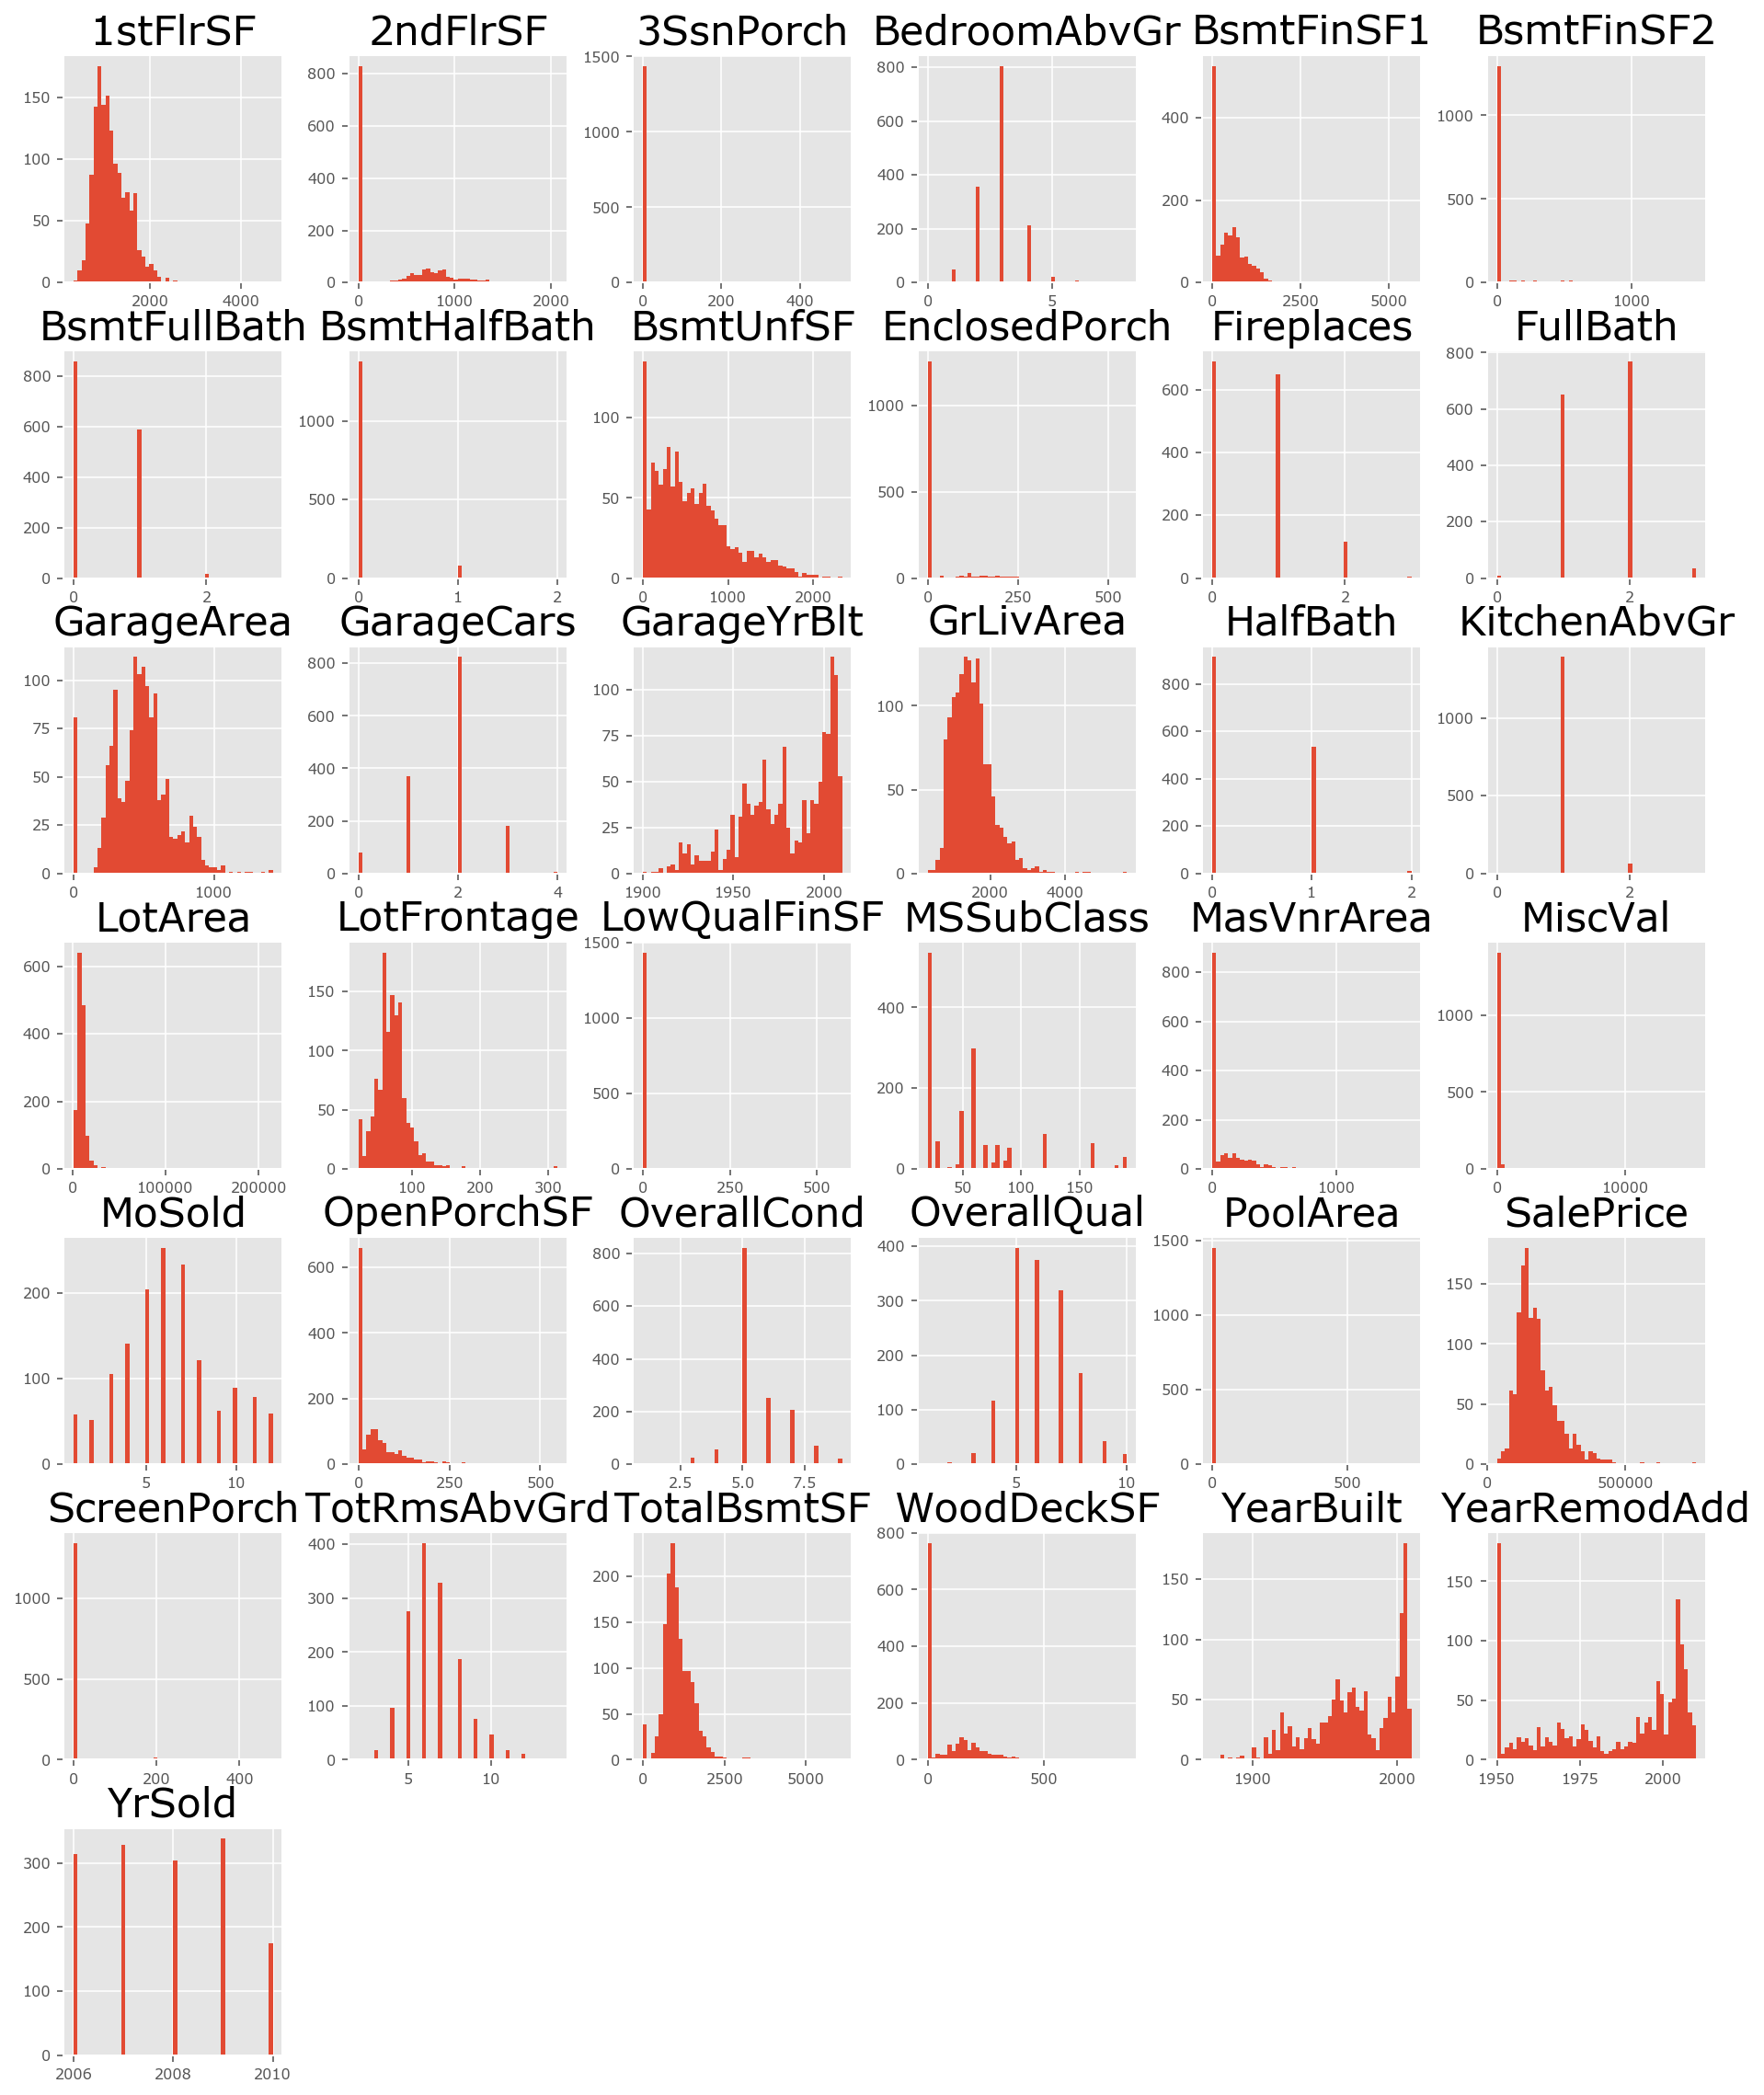

In [8]:
df_sub.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

In [9]:
df_sub_columns =['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea']

In [134]:
df_sub[df_sub_columns].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
# ; avoid having the matplotlib verbose informations
plt.savefig('multiple_distplots.png')

<hr style="border: 4px dashed #aaaaaa; border-style: none none dashed; color: #fff; background-color: #fff;"/>

### Focus on target feature

Examine our target variable or "feature" – `SalePrice`

##### Descriptors

In [10]:
display(df.SalePrice.describe())

count     1460.00000
mean    180921.19589
std      79442.50288
min      34900.00000
25%     129975.00000
50%     163000.00000
75%     214000.00000
max     755000.00000
Name: SalePrice, dtype: float64

This gives us some more insight:

* Prices **range from 34'900 USD to a hefty 755'000**.
* The **average sale price (the mean) is 180'921 USD**. 
* The **median is lower: 163'000 USD**. This is to be expected since the _mean_ is sensitive to outliers and in this case pulled towards outlying higher values. 
* The **standard deviation** is around 79k. So on average, prices in the dataset tend to vary by this amount around the mean of ~180k.

##### Plotting the distribution

In [136]:
#plt.figure(figsize=(16,5))
fig, ax = plt.subplots(2,1, figsize=(16,12))

df.SalePrice.plot(kind="hist", bins=100, rwidth=0.9, ax=ax[0])
ax[0].set_title("Sales Price value distribution")
ax[0].set_xlabel("Sales Price")


plt.figure(figsize=(16,5))
df.SalePrice.plot(kind="box", vert=False, ax=ax[1])
ax[1].violinplot(dataset=df.SalePrice.values, vert=False)
#ax[1].set_title("Sales Price value distribution")
ax[1].set_xlabel("Sales Price")
ax[1].set_yticks([0], [''])
ax[1].set_ylabel("\n", rotation=90)

fig.tight_layout();
fig.savefig('distributions_and_boxplot.png')

<Figure size 1152x360 with 0 Axes>

#### Skewness and deviations from normality

Now that we have identified outliers, characterize distribution.

[**Skewness**](https://en.wikipedia.org/wiki/Skewness). 
* A normal distribution has a skewness of `0`.
* A positive value of skewness means that the tail is on the right, and vice versa with negative values. 
* Pandas/Scipy provides a convenient function, `probplot` (see below), to visualize the skewness

[**Probability plot**](https://en.wikipedia.org/wiki/Normal_probability_plot)
* sorted data are plotted vs. values
* used to identify substantive departures from normality
    * Deviations from a straight line suggest departures from normality.
    * identifying outliers, skewness, kurtosis, a need for transformations, and mixtures. 
* made of raw data, residuals from model fits, and estimated parameters.
* theoretical quantiles approximate either the mean or the median of the corresponding order statistics.

The skewness of SalePrice is: 1.88


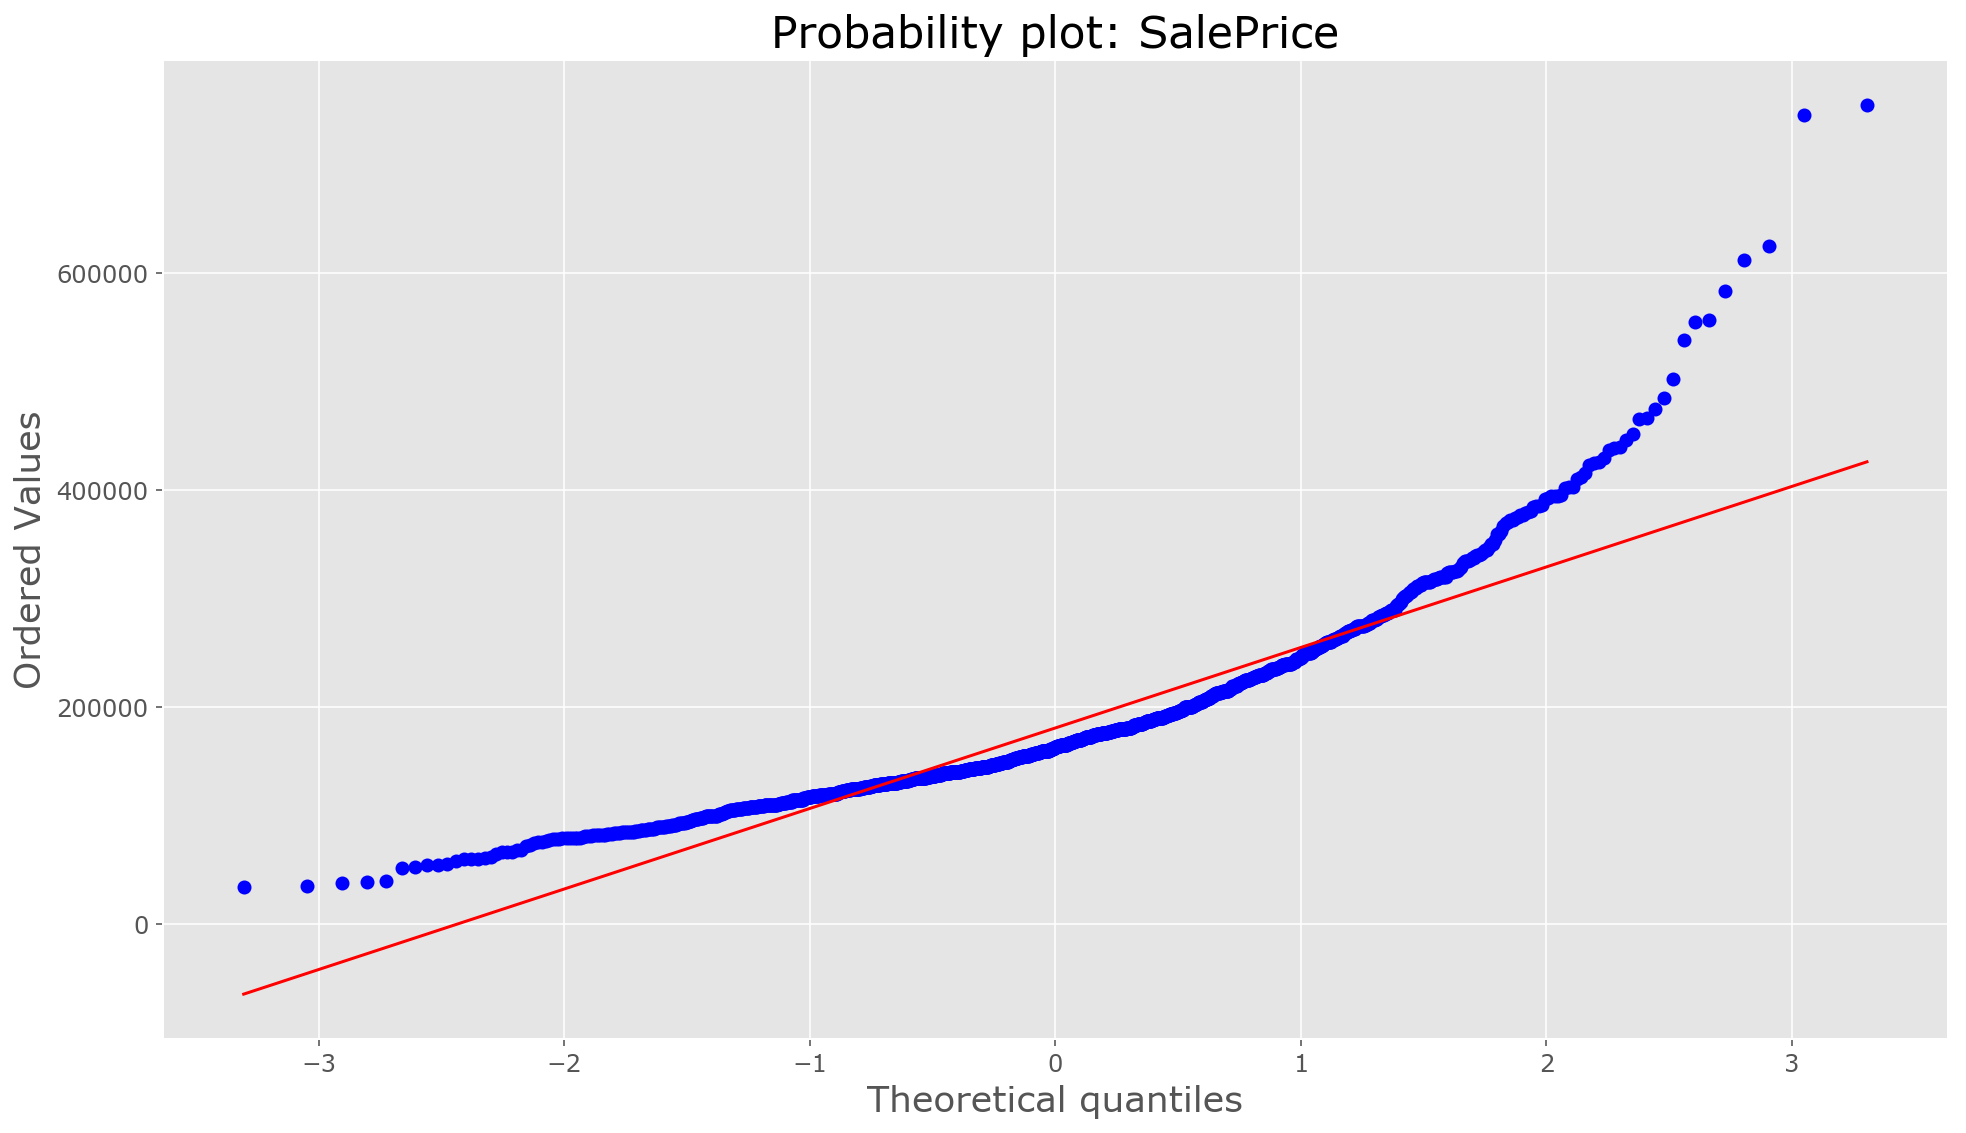

In [11]:
print(f"The skewness of SalePrice is: {df.SalePrice.skew():.2f}")

plt.figure(figsize=(16,9))
_ = stats.probplot(df['SalePrice'], plot=plt)
plt.title("Probability plot: SalePrice")
plt.show()

As expected the skewness is a positive value. From the plot we can observe the deviations from the expected, theoretical values of normal distribution. These also makes sense – they tend to be higher than expected on the right end – making it a long tail.

#### Log-normal distribution

Since the skewness is positive and deviations from normal distribution are evident, check for log-normal distribution: log transform the target feature distribution and plot again.

In [12]:
logSalePrice = np.log1p(df.SalePrice.values)
print(f"Skewness of log transformed sale prices: {pd.DataFrame(logSalePrice).skew().values[0]:.2f}")

plt.figure(figsize=(16,5));
plt.hist(logSalePrice, bins=100, rwidth=0.9)
plt.title("SalePrice log transformed")
plt.xlabel("SalePrice distribution – log transformed")
plt.show()

Skewness of log transformed sale prices: 0.12


<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 5.0px;"/>

### Feature correlations

#### Numerical features correlations to target feature `SalePrice` 

Questions to ask: 
* which features are highly correlated? and what is the threshold for "highly correlated"?
* do the correlations make sense?
    * may need to consult the features' descriptions
* which missing correlations don't make sense?

In [145]:
!pwd

/home/sandm/Slumberland/data-exploration-protocol/boston-reloaded/notebooks


In [11]:
# we drop Id (not relevant)
corr = df.drop(["Id"], axis=1).select_dtypes(include="number").corr()

plt.figure(figsize=(16,16));
corr["SalePrice"].sort_values(ascending=True)[:-1].plot(kind="barh")
plt.title("Correlation of numerical features to SalePrice")
plt.xlabel("Correlation to SalePrice")
plt.tight_layout()
plt.savefig("correlation_with_target_barchart.png")
plt.show()

Not surprisingly most positively correlated features are e.g. the overall quality, living area, number and area of garages. 

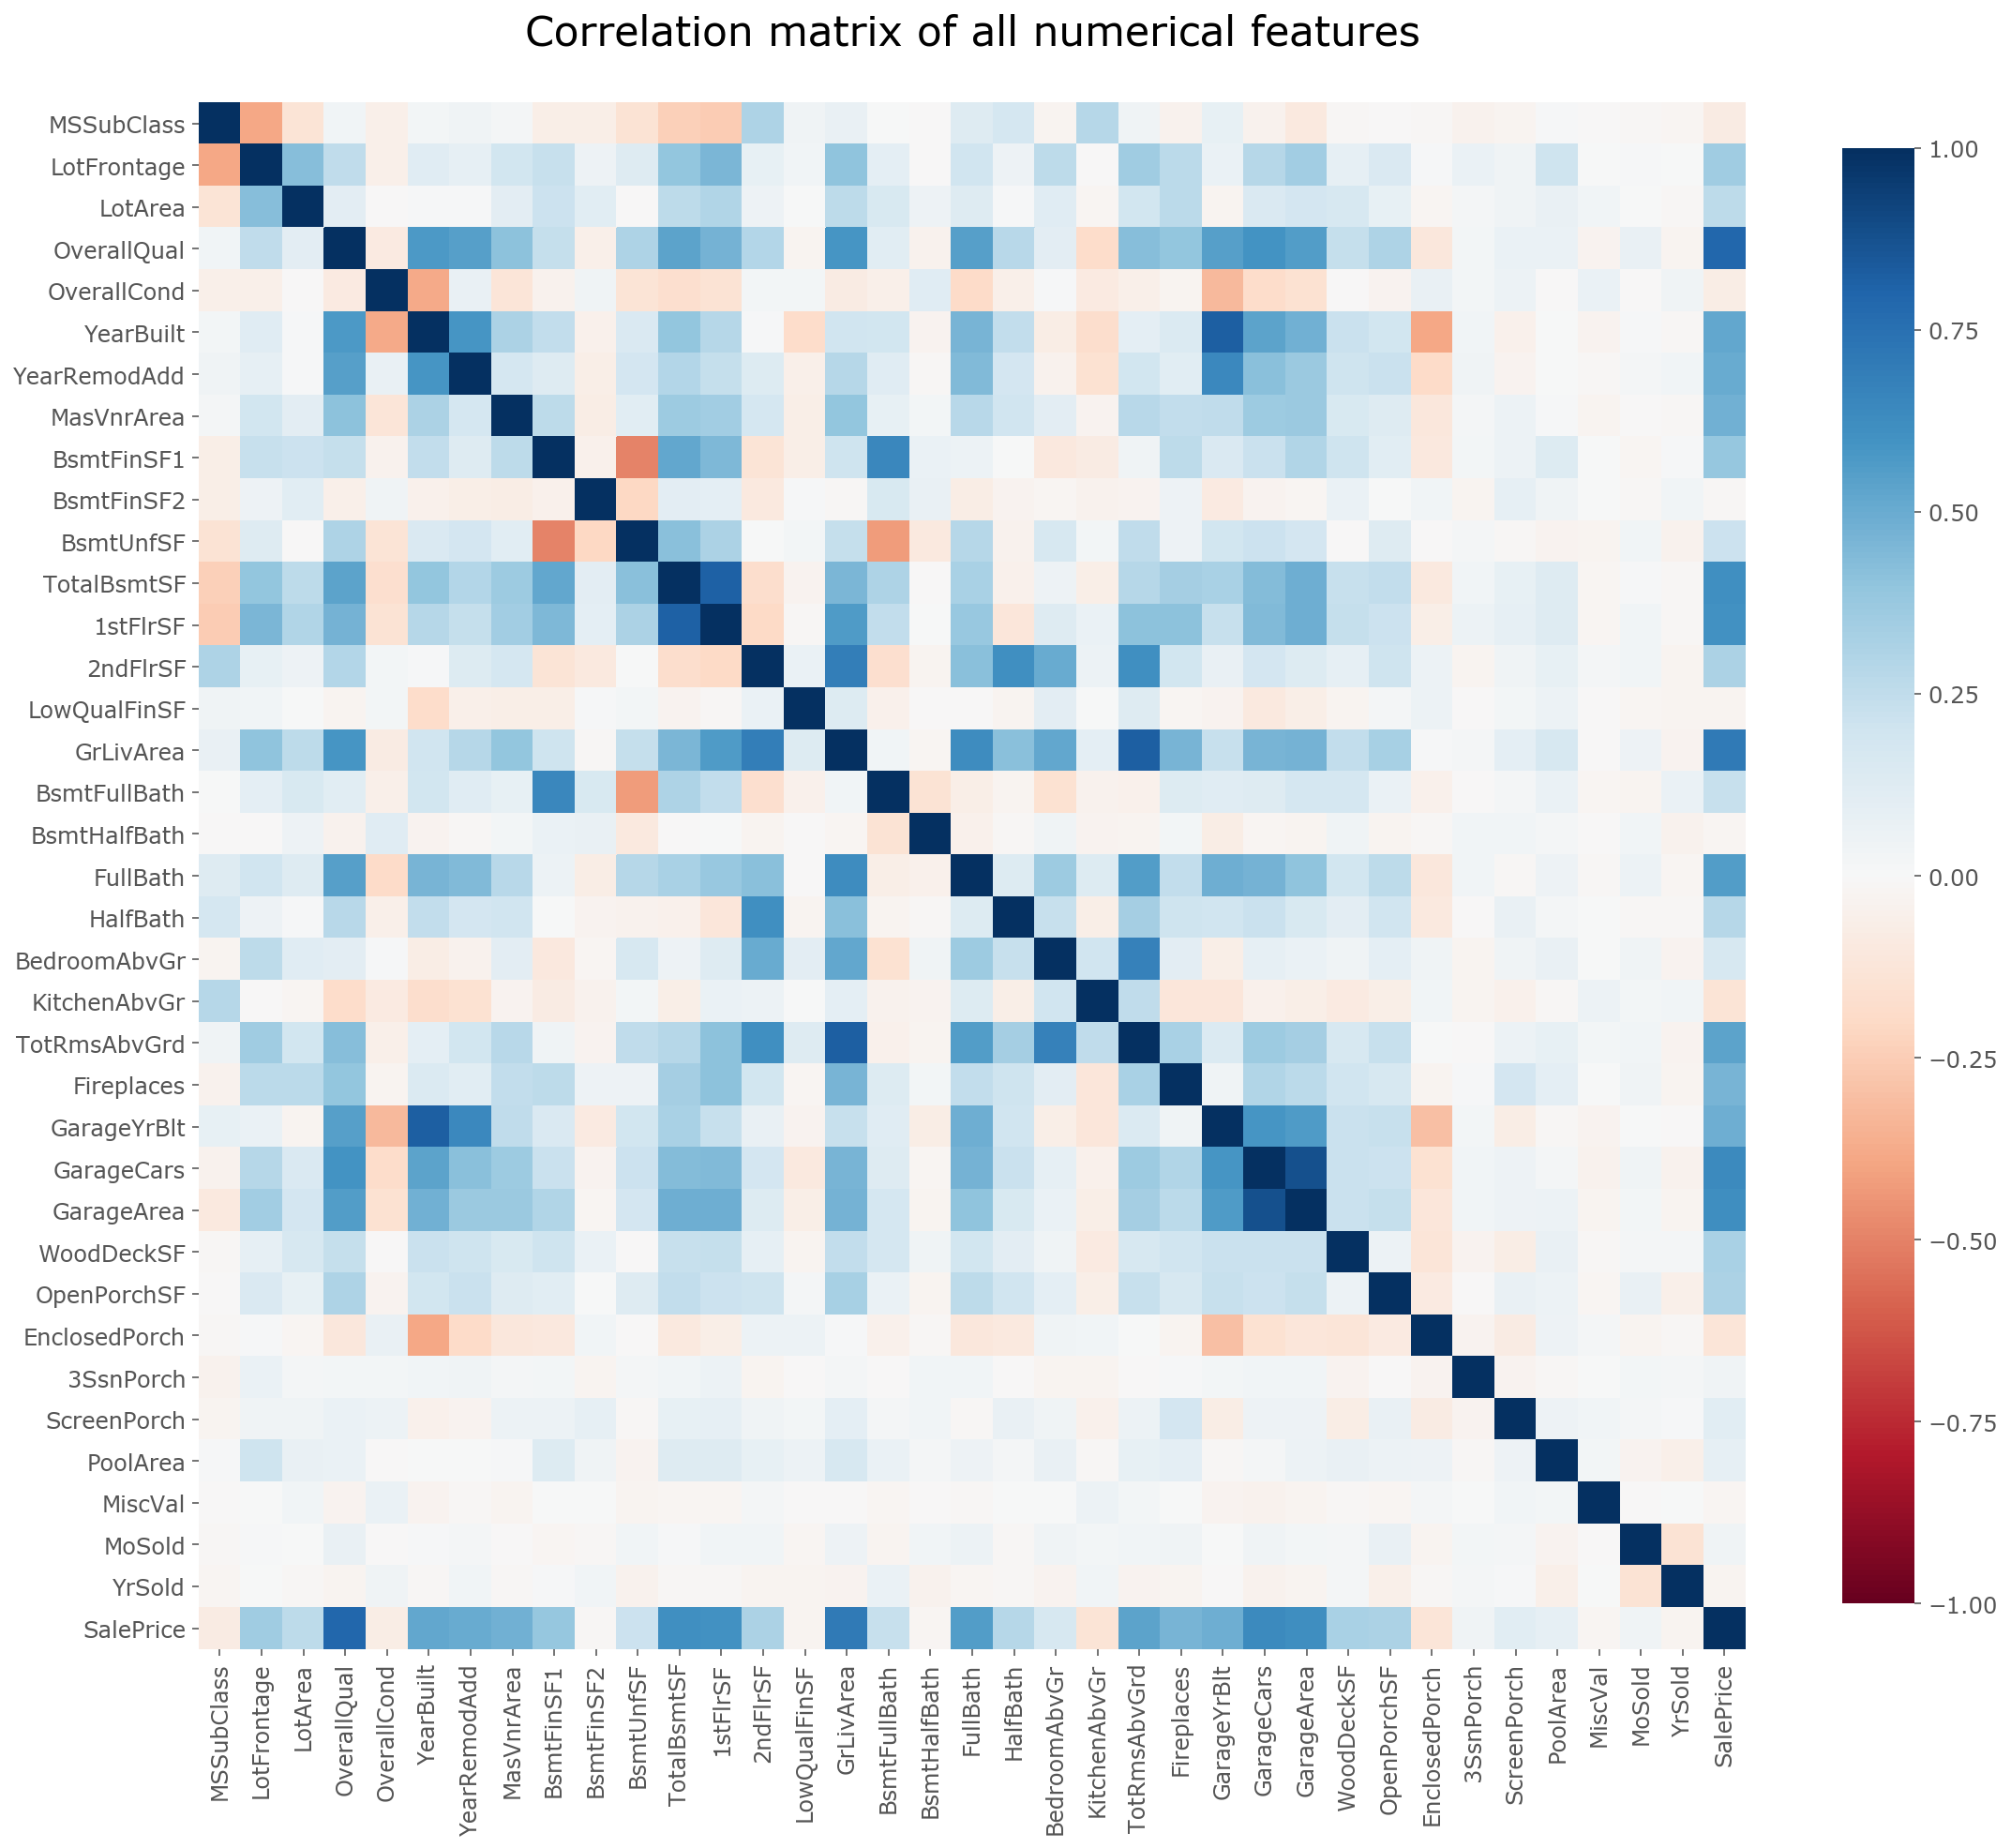

In [13]:
# sort by SalePrice to make more sense in row order
plt.subplots(figsize=(16,16));
sns.heatmap(corr, cmap="RdBu", vmax=1, vmin=-1, square=True, cbar_kws={"shrink": .7})
plt.title("Correlation matrix of all numerical features\n")
plt.tight_layout()
plt.show()

### scatter-pairplots
<font color='red' size=2>**Question** How does one interpret these?
* what to look for?
* how does color-coding the scattered points help?
</font>
**note** also see the net set below; there are some "boundaries"

In [15]:
nr_of_cols_to_plot = 6

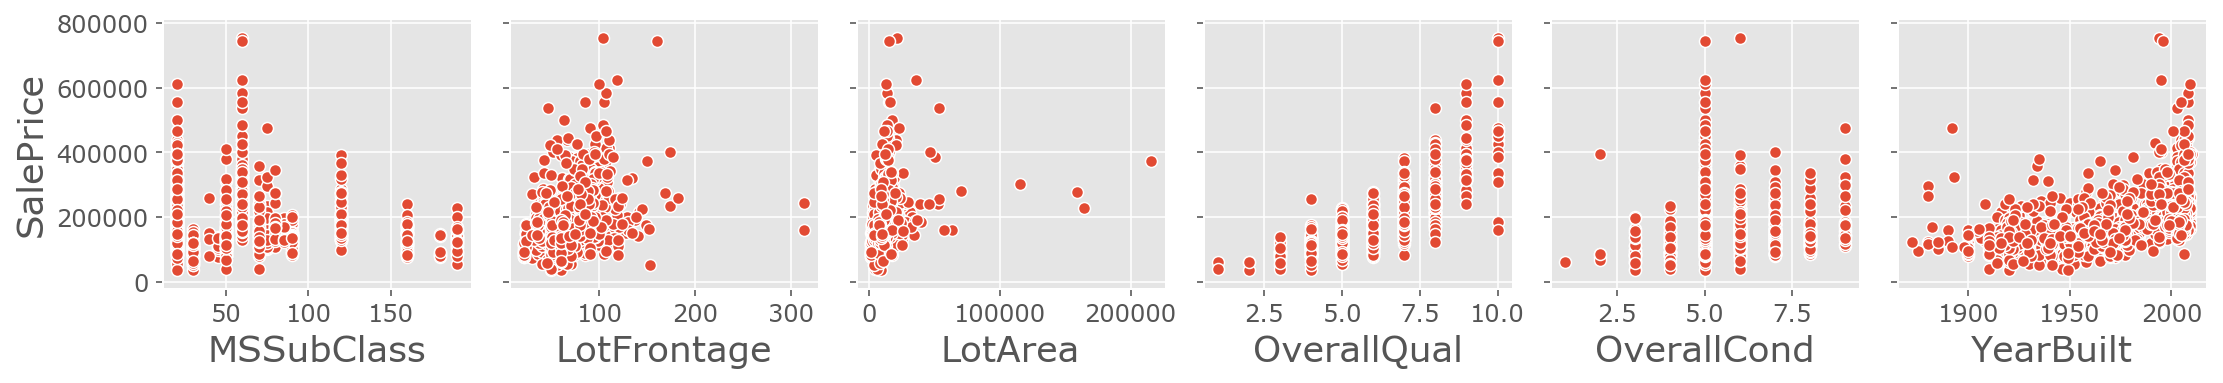

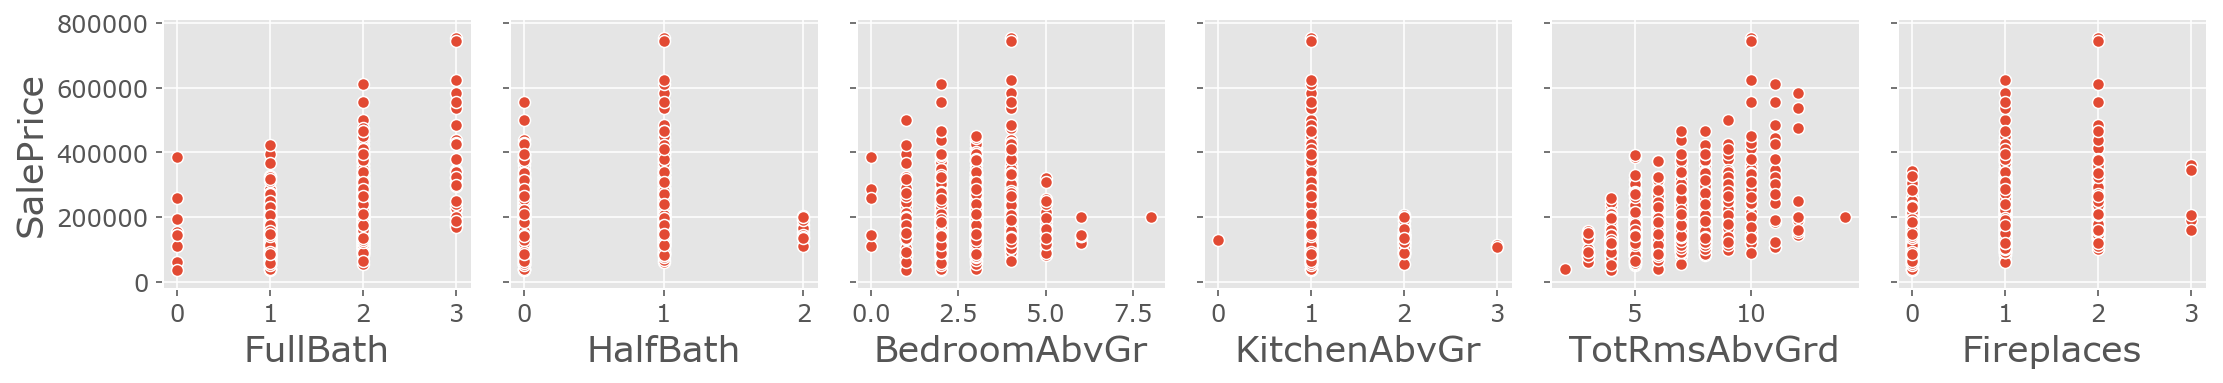

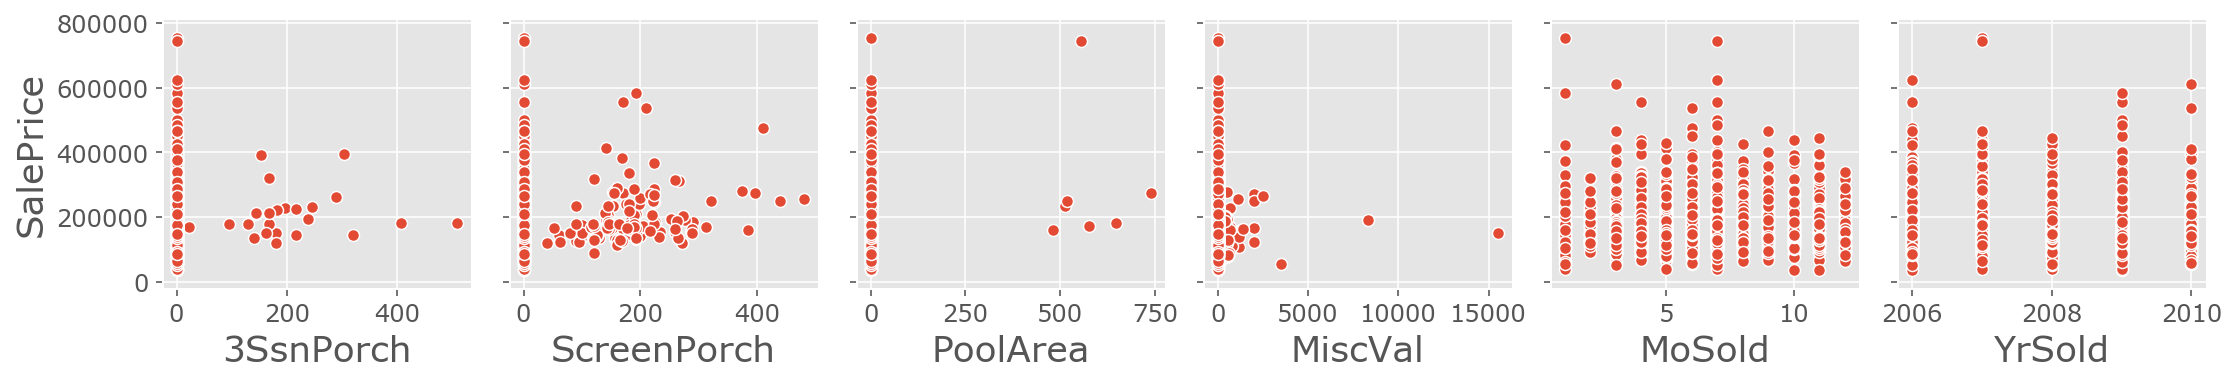

In [16]:
for i in range(0, len(df_sub.columns)-1, nr_of_cols_to_plot):
    sns.pairplot(data=df_sub,
                x_vars=df_sub.columns[i:i+nr_of_cols_to_plot],
                y_vars=['SalePrice'])

In [14]:
twentyfive  = df_sub['SalePrice'].describe().transpose()['25%']
seventyfive = df_sub['SalePrice'].describe().transpose()['75%']

In [15]:
def sale_price_categ(t5, s5):
    def meth(sale_price):
        if (sale_price >= t5) and (sale_price < s5):
            return 0
        elif sale_price >= s5:
            return 1
        else:
            return -1
    return meth

df_sub['SalePriceSplit'] = df_sub['SalePrice'].apply(sale_price_categ(twentyfive, seventyfive))

In [16]:
df_sub.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'SalePriceSplit'],
      dtype='object')

In [17]:
samp_cols = ['LotFrontage', 'LotArea','YearBuilt', 'YearRemodAdd', 
             'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
             'GarageYrBlt', 'SalePrice', 'SalePriceSplit']
# 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',

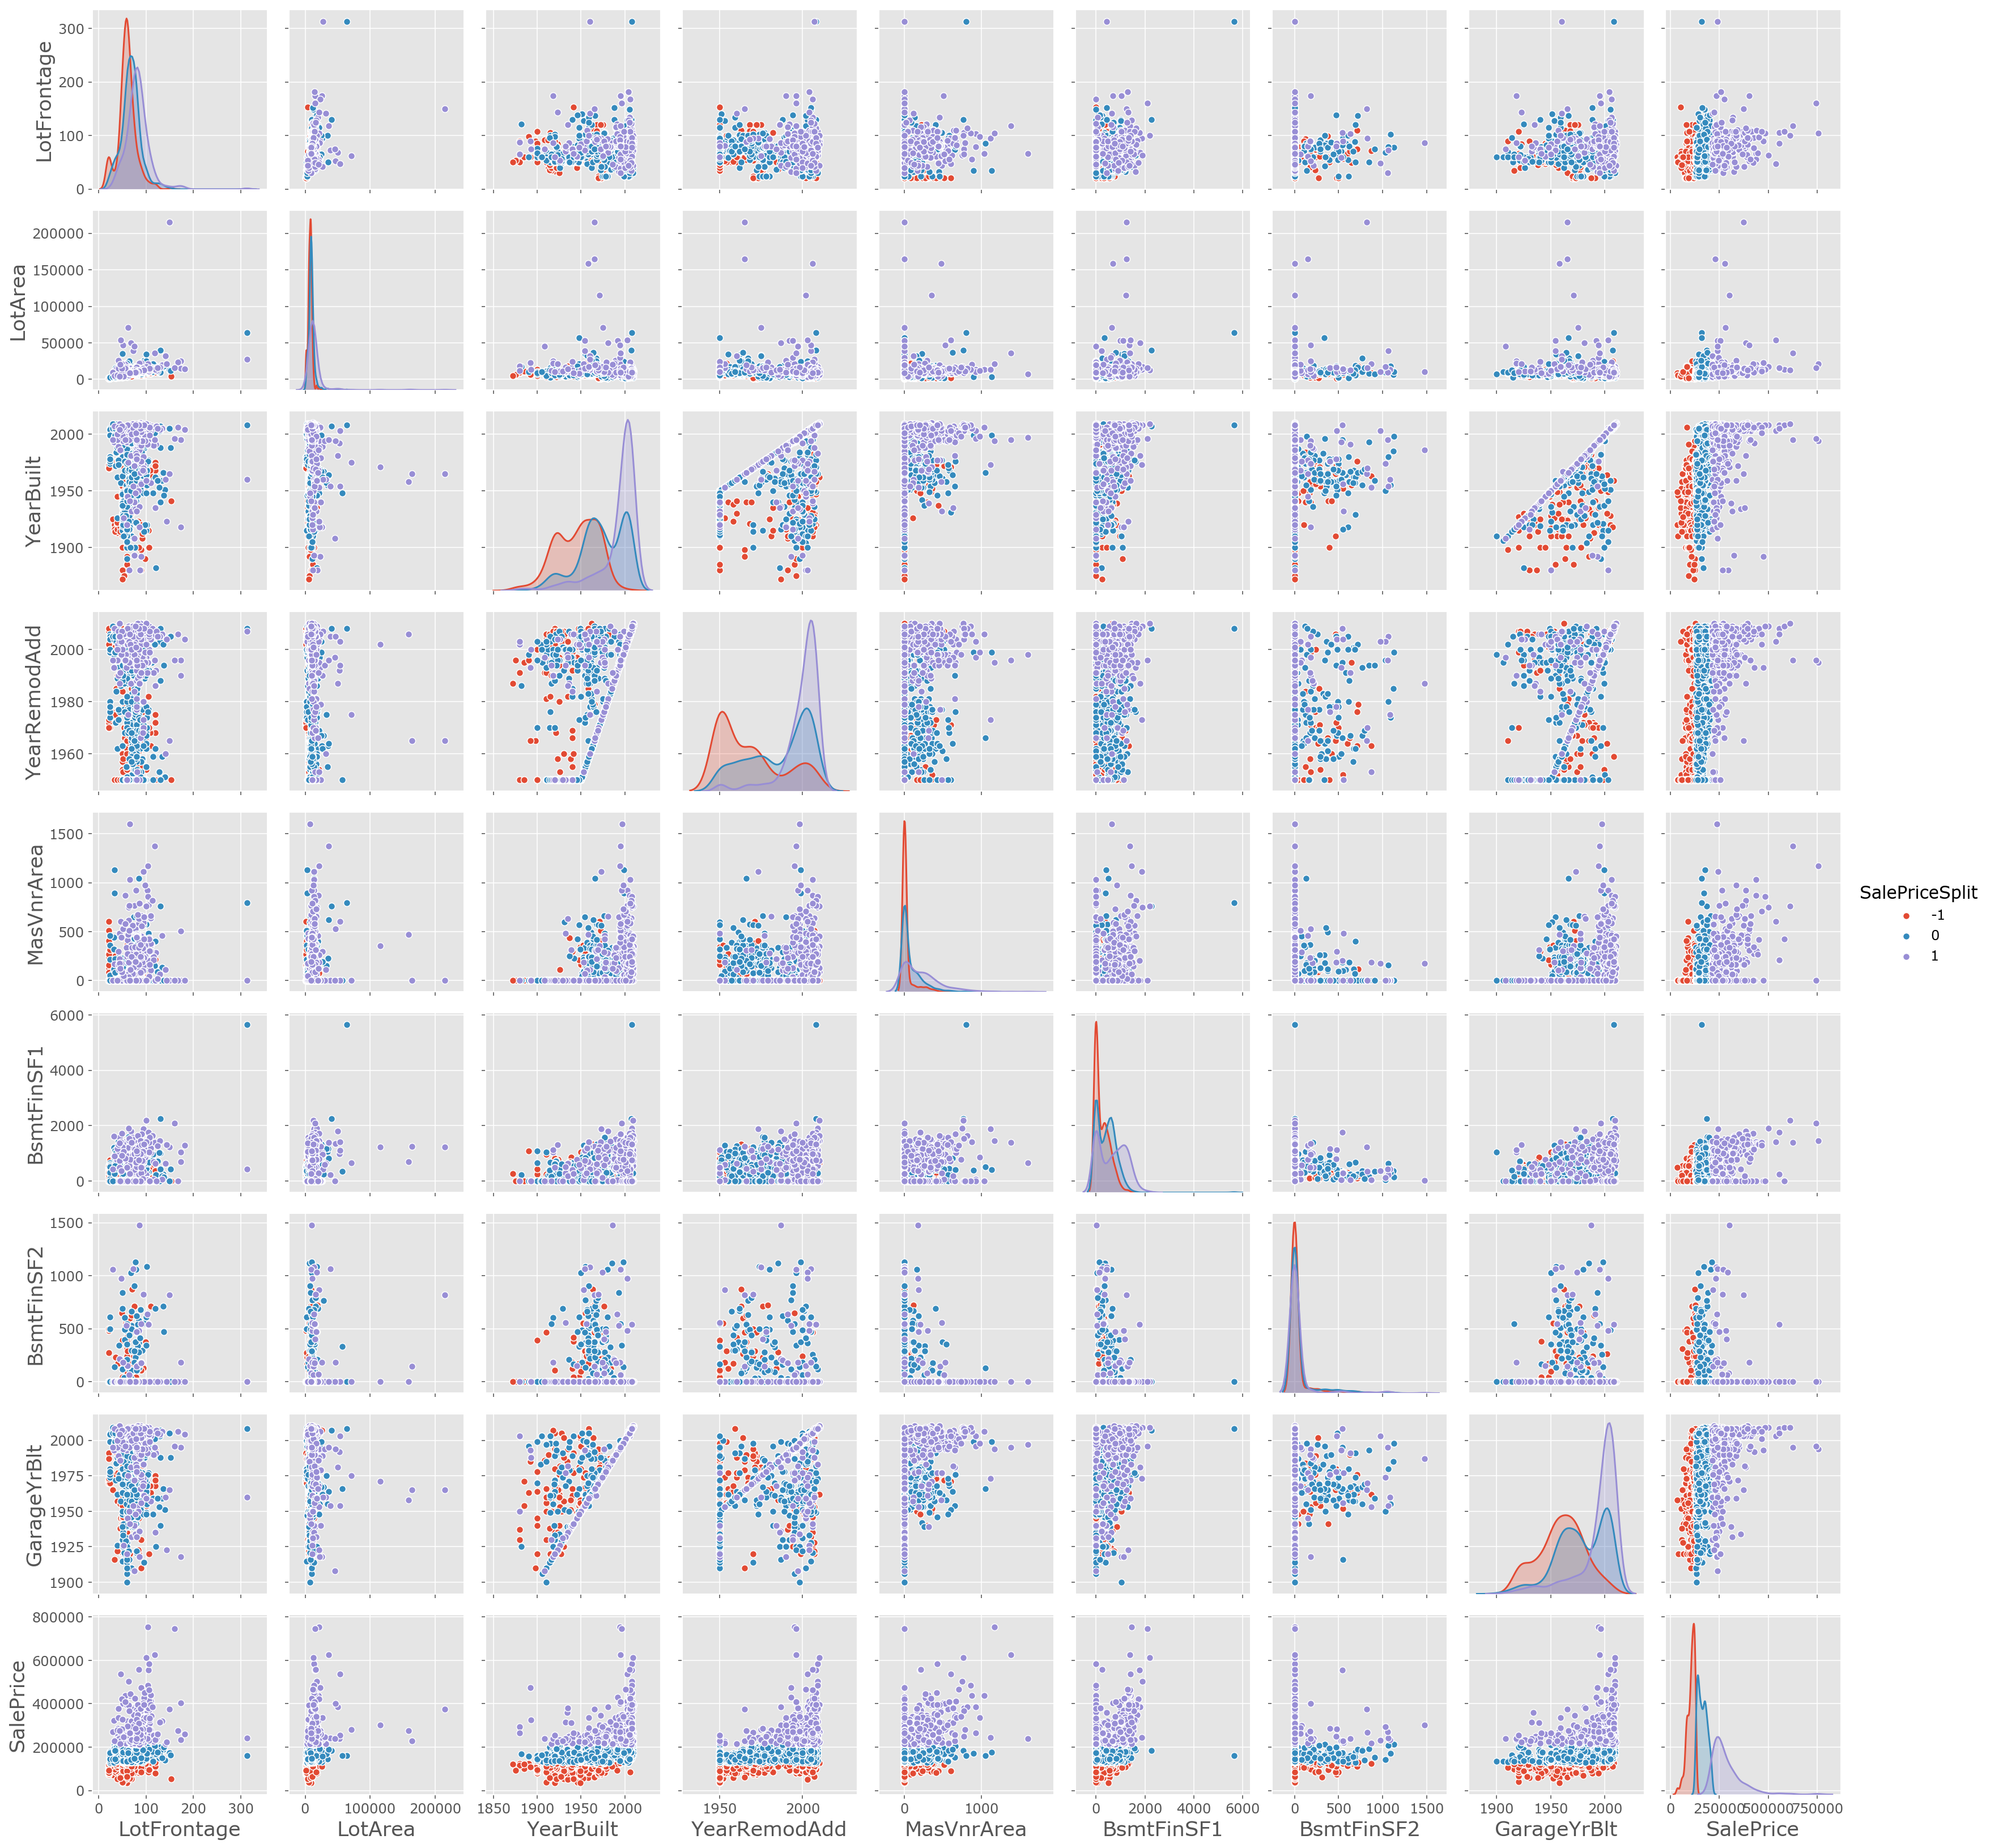

In [34]:
'''
for i in range(0, len(df_sub.columns)-1, nr_of_cols_to_plot):
    sns.pairplot(data=df_sub,
                x_vars=df_sub.columns[i:i+nr_of_cols_to_plot],
                y_vars=['SalePrice'], hue = "SalePriceSplit", diag_kind='kde')
'''    
#sns.pairplot(data, hue = "quality", diag_kind='kde')    
sns.pairplot(df_sub[samp_cols], hue = "SalePriceSplit", diag_kind='kde')

### Plots for correlated categorical data

We are now **examining the relation of our target variable to other interesting correlated features** and start with several numerical **features of size.**

#### Examine the relevant correlations

Consider `SalePrice` (target feature) vs `OverallQual` (test feature):
since the latter is a categorical (ranging from «Very poor» = 1 to «Very Excellent» = 10), can use various plots to gain insights.

><span style="color:darkred">**Note** do not confuse _width of distribution_ with _count of observations_; _ie_ a long box in the plot might visually suggest many values, which is misleading. 

We observe that:
- A higher overall quality results in higher sale price (obviously).
- **The higher the quality the wider the price range.** Poor & very poor quality buildings have almost the same price range while very good to excellent properties have a much wider range of possible sale prices.
- **Most sales range from average to very good (5-8).**
- There are only very few sales on the tails (1-3, 9-10). 
- In most categories we seem to have some outliers on both ends.

Let's plot the **overall condition** in comparison.

We see that:
- Only very few properties are rated below average (5). 
- Average (5) is the category value of overall condition that has by far the most counts.
- **The mean sale price for «Average» is higher than for «Above Average» and higher.**

One possible explanation could be that as long as the house is in average condition it can be fixed to a higher condition without that much additional cost. If the base materials and finish are not good, than a prospective owner would have much more difficulties upping the property. 

By the way: **If we want to visually _combine count and distribution_ we can use a [swarmplot](https://seaborn.pydata.org/generated/seaborn.swarmplot.html#seaborn.swarmplot).** 

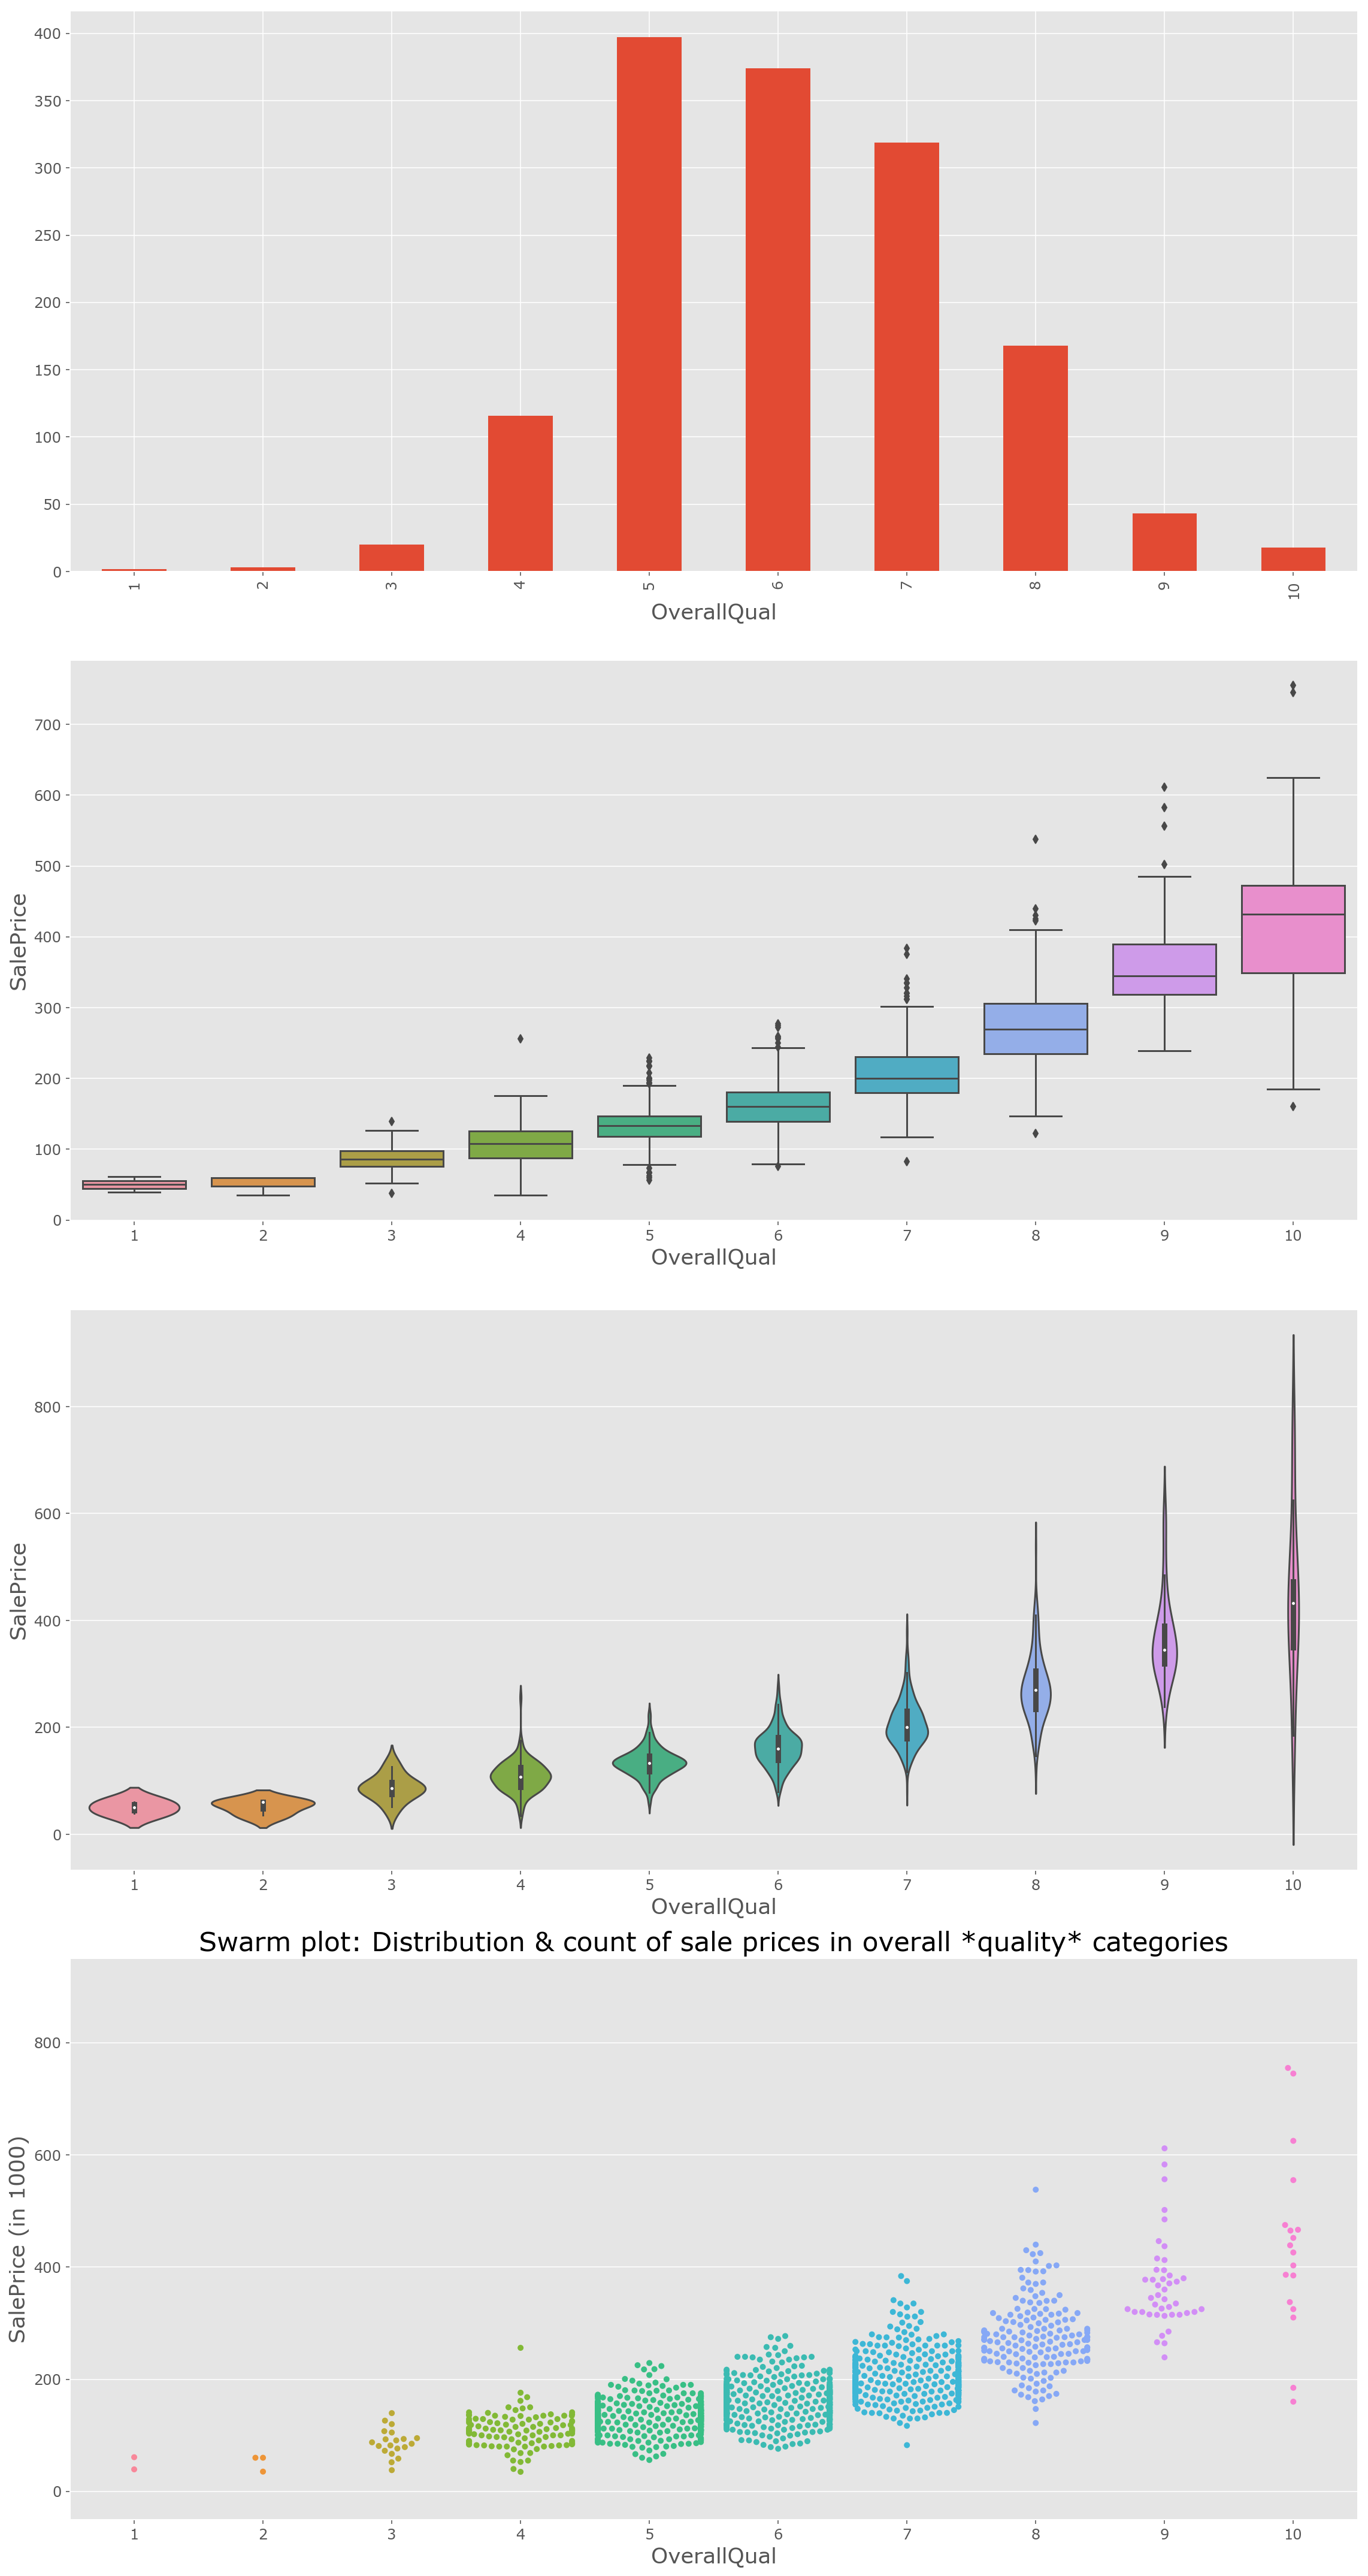

In [143]:
# OverallQual: Rates the overall material and finish of the house
fig, axs = plt.subplots(4,1,figsize=(16,30))

axs = axs.reshape(4)
df.groupby("OverallQual")["SalePrice"].count().plot(kind="bar",ax=axs[0])
plt.title("Count of observations in overall quality categories («OverallQual»)")
plt.ylabel("Count")
#plt.tight_layout()
#plt.show()

#plt.figure(figsize=(16,5));
ax = sns.boxplot(x="OverallQual", y="SalePrice", data=df, ax=axs[1])
plt.title("Distribution of sale prices in overall quality categories («OverallQual»)")
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_1000))
plt.ylabel("SalePrice (in 1000)")
plt.ylim(-50000,950000)
#plt.tight_layout()
#plt.show()

#plt.figure(figsize=(16,5));
ax = sns.violinplot(x="OverallQual", y="SalePrice", data=df, ax=axs[2])
plt.title("Violinplot plot: Distribution & count of sale prices in overall *quality* categories")
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_1000))
plt.ylabel("SalePrice (in 1000)")
plt.ylim(-50000,950000)
#plt.tight_layout()
#plt.show()

#plt.figure(figsize=(16,5));
ax = sns.swarmplot(x="OverallQual", y="SalePrice", data=df, ax=axs[3])
plt.title("Swarm plot: Distribution & count of sale prices in overall *quality* categories")
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_1000))
plt.ylabel("SalePrice (in 1000)")
plt.ylim(-50000,950000)

plt.tight_layout()

plt.savefig('categorical_distributions.png')
plt.show()

The correlation is clearly noticable. 

We also can observe some of **the hefty outliers that Dean De Cock has warned us** about. There are two data points of very high living area and low sale price and two with a rather high sale price.

We try to improve the visualisation by adding the overall condition as hue to the plot. 

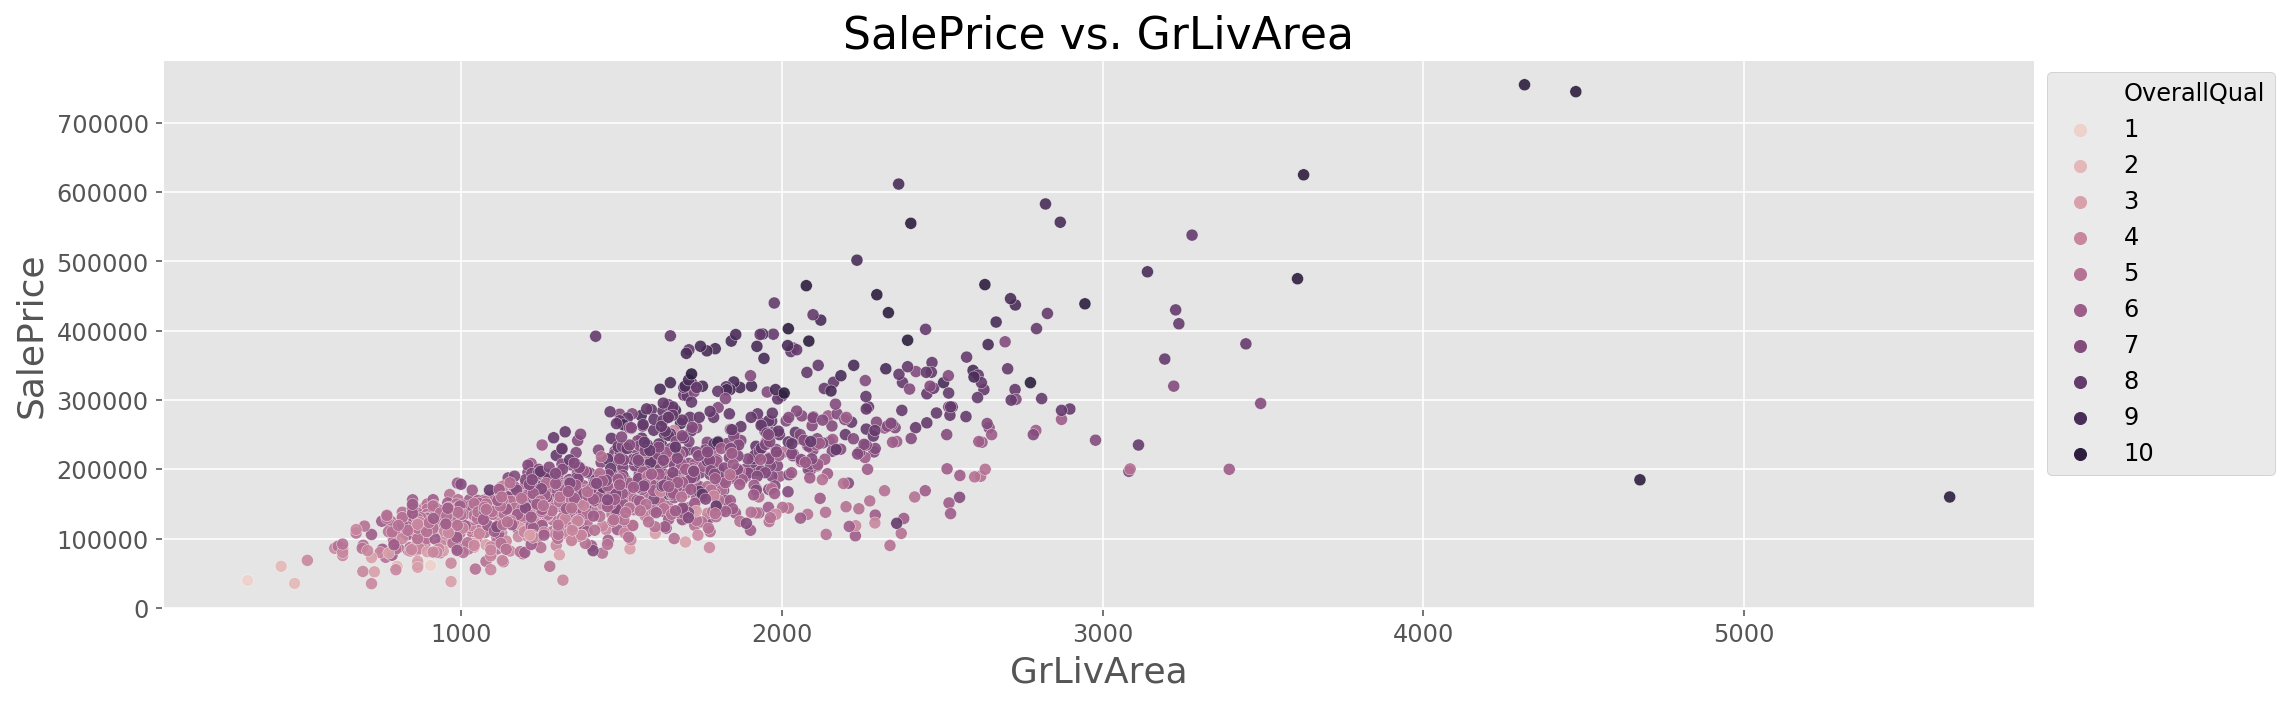

In [19]:
plt.figure(figsize=(16,5));
sns.scatterplot(x="GrLivArea", y="SalePrice", hue="OverallQual", data=df, 
                legend="full", linewidth=0.2, alpha=0.9)
plt.title(f"SalePrice vs. GrLivArea")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.tight_layout()
plt.show()

Makes sense: low overall quality data points plot with light hue in lower ranges of living area and sale price. 

Binning a continuous feature (`GrLivArea`) to discrete values, and plot again counts and distribution, can reveal evidence for a correlation.

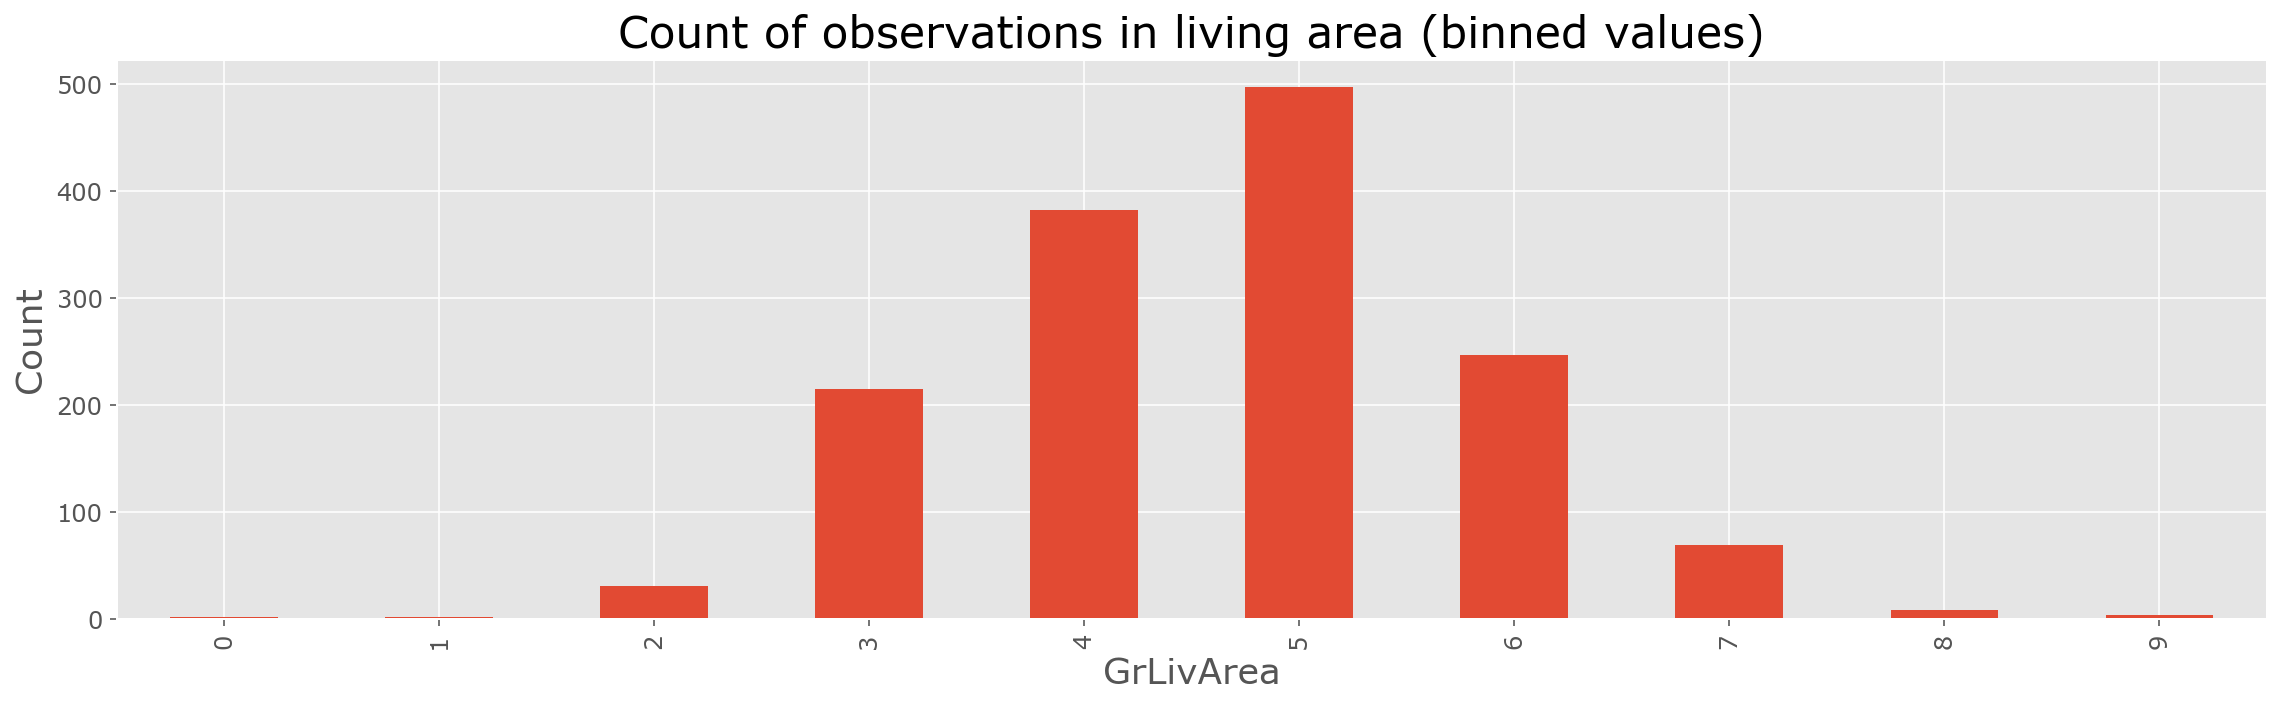

In [18]:
df_cut = pd.DataFrame(pd.cut(np.log(df.GrLivArea), bins=10, labels=np.arange(0,10)))
df_comb = pd.concat([df_cut, df.SalePrice], axis=1)

plt.figure(figsize=(16,5));
df_comb.groupby("GrLivArea").SalePrice.count().plot(kind="bar")
plt.title("Count of observations in living area (binned values)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9));
ax = sns.boxplot(x="GrLivArea", y="SalePrice", data=df_comb)
plt.title("Distribution of observations in living area (binned values)")
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_1000))
plt.ylabel("SalePrice (in 1000)")
plt.tight_layout()
plt.show()

Main finding: **The more living area the more variance we have in the distribution of sale prices.** In the top range of living area we find unusual high variance – very likely due to the outliers.

Now checking 4 more features of size.

GarageArea 0.6234314389183598


<Figure size 1152x360 with 0 Axes>

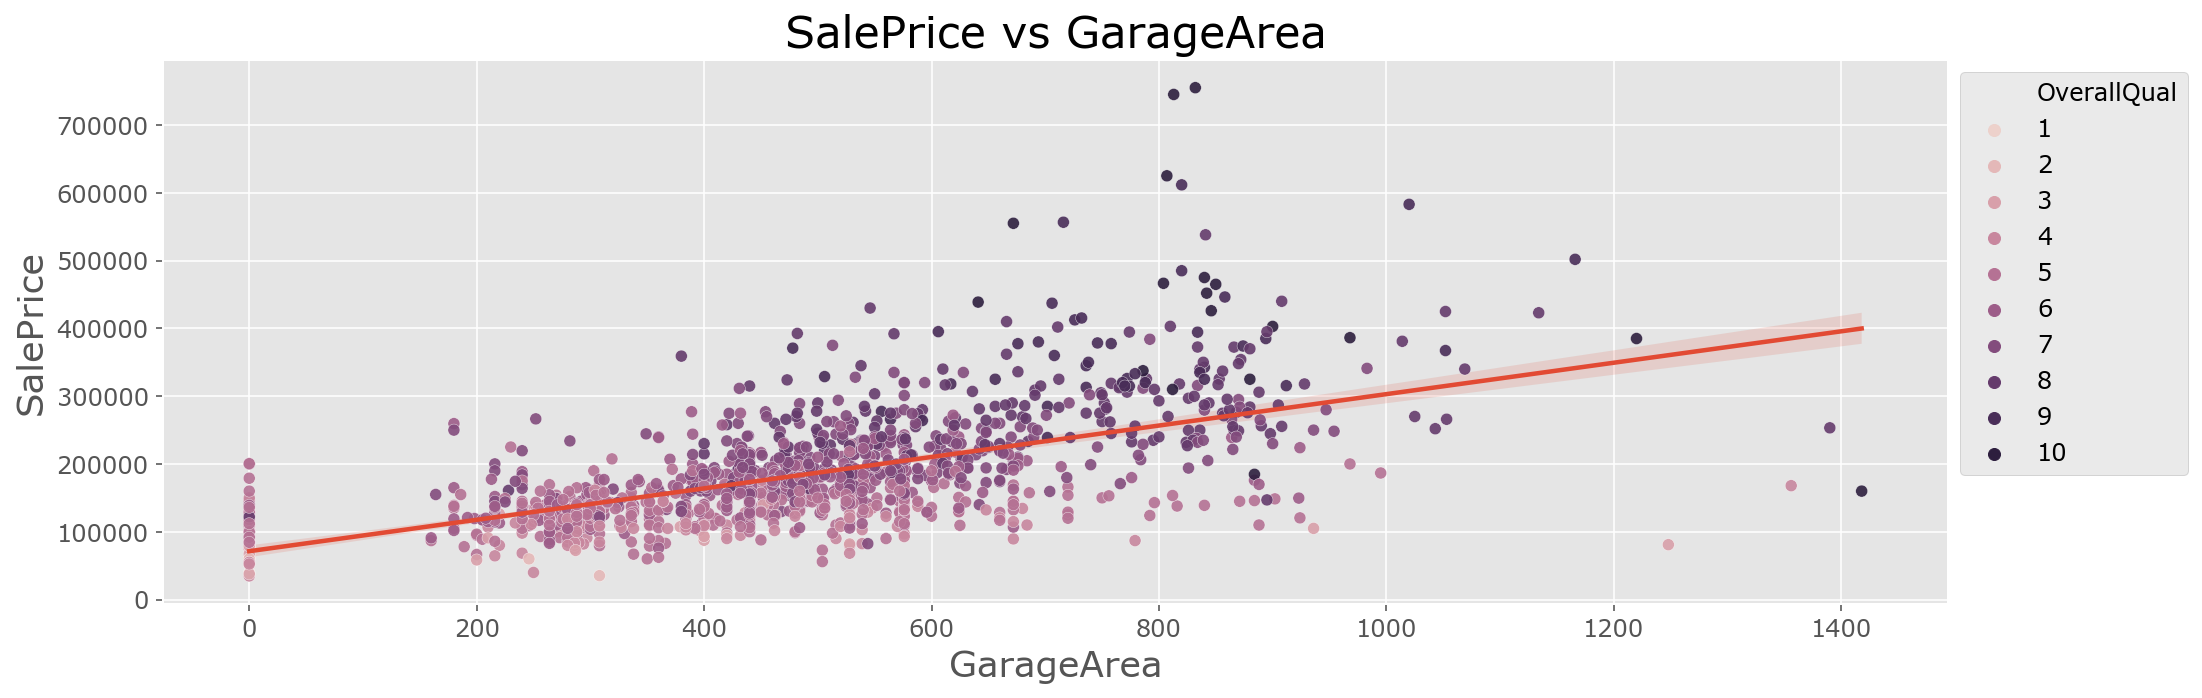

TotalBsmtSF 0.6135805515591944


<Figure size 1152x360 with 0 Axes>

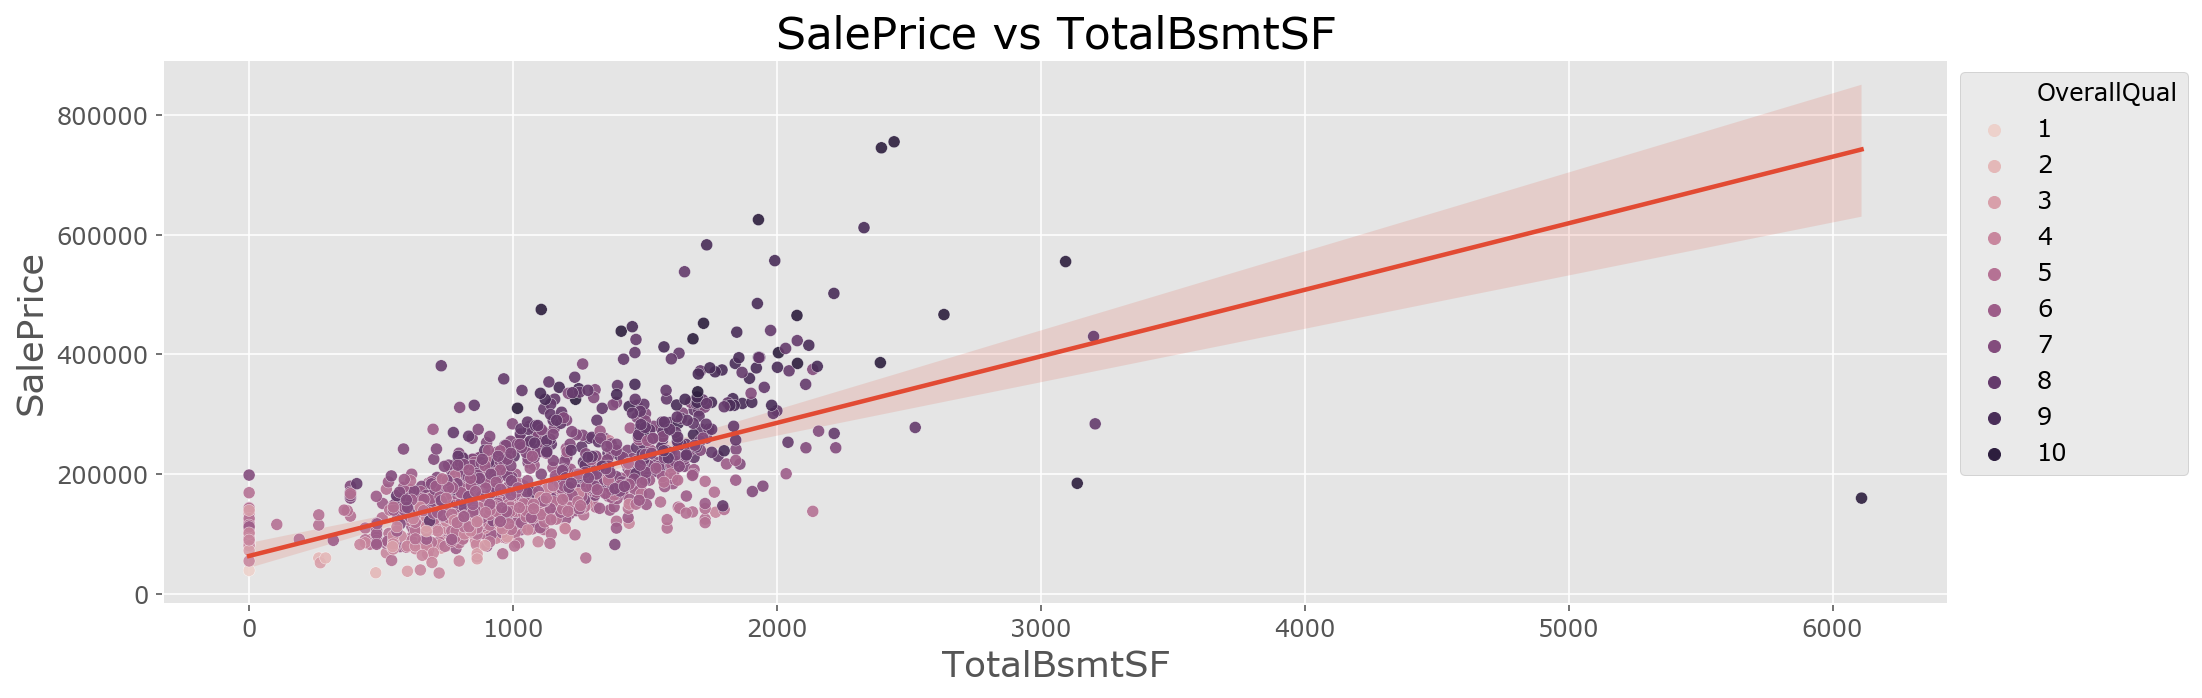

1stFlrSF 0.6058521846919166


<Figure size 1152x360 with 0 Axes>

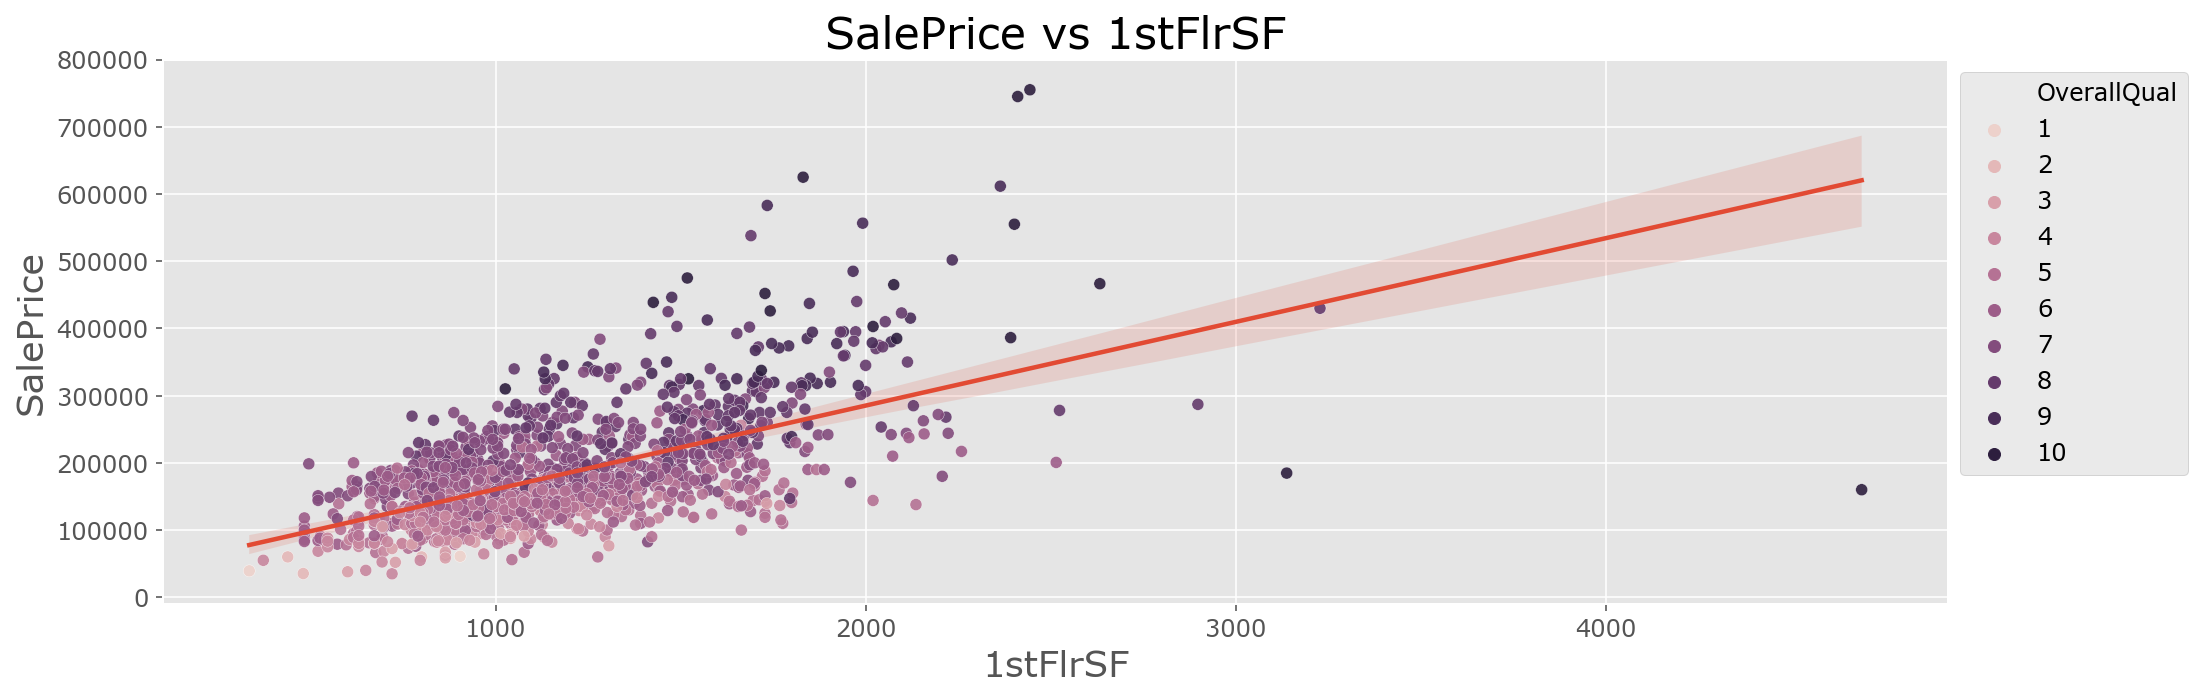

LotArea 0.2638433538714063


<Figure size 1152x360 with 0 Axes>

In [19]:
features = ["GarageArea", "TotalBsmtSF", "1stFlrSF", "LotArea"]
target_feature = "SalePrice"
for feature in features:
    plt.figure(figsize=(16,5));
    
    corr = df[[target_feature, feature]].corr('pearson')[feature][target_feature]
    print(feature, corr)
    plt.figure(figsize=(16,5));
    sns.regplot(x=feature, y=target_feature, scatter=False, data=df)    
    sns.scatterplot(x=feature, y=target_feature, hue="OverallQual", data=df, 
                legend="full", linewidth=0.2, alpha=0.9)
    plt.legend(bbox_to_anchor=(1, 1), loc=2)
    plt.title(f"{target_feature} vs {feature}")
    plt.show()

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 5.0px;"/>

# 2. Data cleaning and formatting

## 

#### Outliers in the target feature 

[Taken from machinelearningmastery.com:](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)


* distribution of `SalePrice` is quite skewed $\to$ not normally distributed at all. 
* many outliers on the upper end
    * But what are outlier? 
    > * unlike the other observations: rare, distinct, or does not fit 
    > * caused by measurement or input error, data corruption or true outlier observation
    > * specific to each dataset $\to$ must interpret the raw observations and decide
    > * do not follow learnable pattern $\to$ likely decrease models accuracy 
    * possible to isolate the outliers with statistical methods?
    > * for _normally distributed data_, filter values outside 3 standard deviations from the mean. 
    > * otherwise can use the **Interquartile Range Method**
    >     * outer bounds of a regular distribution are 1.5 * IQR (difference between the 25th and 75th percentile range)

The IQR is the difference between the 25th and 75th percentile range (e.g. the width of the box in the boxplot above). The outer bounds of a regular distribution are 1.5 * IQR. **A factor (called «k») of 3 or more can be used to identify values that are extreme outliers.** So let's try that.



In [20]:
# calculate percentiles and IQR
q25 = percentile(df.SalePrice, 25)
q75 = percentile(df.SalePrice, 75)
iqr = q75 - q25

# calculate normal and extreme upper and lower cut off
cut_off = iqr * 3
lower = q25 - cut_off 
upper = q75 + cut_off

print(f'Percentiles:\n25th  =  {q25}\n75th  =  {q75}\n\nIQR   =   {iqr}\nlower = {lower}\nupper =  {upper}')

Percentiles:
25th  =  129975.0
75th  =  214000.0

IQR   =   84025.0
lower = -122100.0
upper =  466075.0


* The lower bound is negative and therefore can be ignored $\to$ set lower bound to 0
* The upper bound is 466'075 USD $\to$ filter samples above this threshold

In [21]:
df[df.SalePrice > upper].head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
178  179          20       RL     63.00000    17423   Pave   NaN      IR1   
185  186          75       RM     90.00000    22950   Pave   NaN      IR2   
440  441          20       RL    105.00000    15431   Pave   NaN      Reg   
691  692          60       RL    104.00000    21535   Pave   NaN      IR1   
769  770          60       RL     47.00000    53504   Pave   NaN      IR2   

    LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
178         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
185         Lvl    AllPub  ...        0    NaN  GdPrv         NaN       0   
440         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
691         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
769         HLS    AllPub  ...        0    NaN    NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
178      7   2009       New        Partial     501837  
185      6   2006        WD         Normal     475000  
440      4   2009        WD         Normal     555000  
691      1   2007        WD         Normal     755000  
769      6   2010        WD         Normal     538000  

[5 rows x 81 columns]

In this step we will:
    
- find and fix missing and/or wrong values
- set correct datatypes
- remove outliers

We start by **plotting all numeric features according to the current pandas dtypes.**

In [22]:
# start fresh with again reading in the data
df = pd.read_csv(f"{BASE_PATH}train.csv")
df_test = pd.read_csv(f"{BASE_PATH}test.csv")

# concat all samples to one dataframe for cleaning
# need to be careful not to leak data from test to training set! 
# e.g. by filling missing data with mean of *all* samples rather than training samples only
feat = pd.concat([df, df_test]).reset_index(drop=True).copy()

In [23]:
fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(16,36))
num = feat.drop(["Id", "SalePrice"], axis=1).select_dtypes("number")

for idx, column in enumerate(num.columns[1:]):
    num[column].plot(kind="hist", bins=100, rwidth=.9, title=column, ax=axes[idx//2, idx%2])
    ax=axes[idx//2, idx%2].yaxis.label.set_visible(False)

#plt.tight_layout()
plt.show()

We immediately notice that some features of `dtype == "number"` are categorical, many values are zeros and almost all value distributions seem skewed. From the initial `df.info()` we also can derive that there are float where ints should be. It's basically a mess.

Let's fix the features one by one.

In [118]:
# get columns with NaN values
missing = feat.columns[feat.isna().any()]
print(missing)

Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF',
       'Utilities'],
      dtype='object')


In [119]:
# fix missing values in features

# Alley: NA means no alley acces so we fill with string «None»
feat.Alley = feat.Alley.fillna("None")

# BsmtQual et al – NA for features means "no basement", filling with string "None"
bsmt_cols = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
for col in bsmt_cols:
    feat[col] = feat[col].fillna("None")

# Basement sizes: NaN likely means 0, can be set to int
for col in ['BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']:
    feat[col] = feat[col].fillna(0).astype(int)
    
# Electrical: NA likely means unknown, filling with most frequent value SBrkr
feat.Electrical = feat.Electrical.fillna("SBrkr")

# Exterior1st: NA likely means unknown, filling with most frequent value VinylSd
feat.Exterior1st = feat.Exterior1st.fillna("VinylSd")

# Exterior2nd: NA likely means no 2nd material, filling with «None»
feat.Exterior2nd = feat.Exterior2nd.fillna("None")

# Fence: NA means «No Fence» filling with «None»
feat.Fence = feat.Fence.fillna("None")

# FireplaceQu: NA means «No Fireplace» filling with «None»
feat.FireplaceQu = feat.FireplaceQu.fillna("None")

# Functional: NA means «typical» filling with «Typ»
feat.Functional = feat.Functional.fillna("Typ")

# GarageType et al – NA means "no garage", filling with string "None"
grg_cols = ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']
for col in grg_cols:
    feat[col] = feat[col].fillna("None")

# Garage sizes: NaN means «no garage» == 0, unsure if build year should be 0?
for col in ['GarageArea', 'GarageCars', 'GarageYrBlt']:
    feat[col] = feat[col].fillna(0).astype(int)

# fix one outlier GarageYrBlt == 2207
to_fix = feat[feat.GarageYrBlt == 2207].index
feat.loc[to_fix, "GarageYrBlt"] = int(feat.GarageYrBlt.mean())
    
# KitchenQual: filling NaNs with most frequent value «Typical/Average» («TA»)
feat.KitchenQual = feat.KitchenQual.fillna("TA")

# LotFrontage can be set to integer, filling missing values with 0
feat.LotFrontage = feat.LotFrontage.fillna(0).astype(int)

# MSZoning filling NaNs with most frequent value «RL» (residental low density)
feat.MSZoning = feat.MSZoning.fillna("RL")

# MSSubClass is encoded numerical but actually categorical
feat.MSSubClass = feat.MSSubClass.astype(str)

# Masonry: NA very likely means no masonry so we fill with string «None» or 0 for size
feat.MasVnrType = feat.MasVnrType.fillna("None")
feat.MasVnrArea = feat.MasVnrArea.fillna(0).astype(int)

# MiscFeature means likely no feature, filling with None
feat.MiscFeature = feat.MiscFeature.fillna("None")

# PoolQC means likely no pool, filling with None
feat.PoolQC = feat.PoolQC.fillna("None")

# SaleType: NaNs likely mean unknown, filling with most frequent value «WD»
feat.SaleType = feat.SaleType.fillna("WD")

# Utilities: NaNs likely mean unknown, filling with most frequent value «AllPub»
feat.Utilities = feat.Utilities.fillna("AllPub")

In [120]:
# label encode ordinal features where there is order in categories
# unfortunately can't use LabelEncoder or pd.factorize() since strings do not contain order of values

feat = feat.replace({  "Alley":        {"None" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond":     {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "BsmtExposure": {"None" : 0, "No" : 2, "Mn" : 2, "Av": 3, 
                                        "Gd" : 4},
                       "BsmtFinType1": {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, 
                                        "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2": {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, 
                                        "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual":     {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "CentralAir":   {"None" : 0, "N" : 1, "Y" : 2},
                       "ExterCond":    {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, 
                                        "Gd": 4, "Ex" : 5},
                       "ExterQual":    {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, 
                                        "Gd": 4, "Ex" : 5},
                       "Fence":        {"None" : 0, "MnWw" : 1, "GdWo" : 2, "MnPrv": 3, 
                                        "GdPrv" : 4},
                       "FireplaceQu":  {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "Functional":   {"None" : 0, "Sal" : 1, "Sev" : 2, "Maj2" : 3, 
                                        "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, 
                                        "Typ" : 8},
                       "GarageCond":   {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "GarageQual":   {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "GarageFinish": {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
                       "HeatingQC":    {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "KitchenQual":  {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, 
                                        "Gd" : 4, "Ex" : 5},
                       "LandContour":  {"None" : 0, "Low" : 1, "HLS" : 2, "Bnk" : 3, 
                                        "Lvl" : 4},
                       "LandSlope":    {"None" : 0, "Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape":     {"None" : 0, "IR3" : 1, "IR2" : 2, "IR1" : 3, 
                                        "Reg" : 4},
                       "PavedDrive":   {"None" : 0, "N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC":       {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, 
                                        "Ex" : 4},
                       "Street":       {"None" : 0, "Grvl" : 1, "Pave" : 2},
                       "Utilities":    {"None" : 0, "ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, 
                                        "AllPub" : 4}}
                     )

feat.BsmtCond = feat.BsmtCond.astype(int)

In [121]:
# only one hot encode «true» categoricals...  
# ... rather than ordinals, where order matters and we already label encoded in the previous cells

def onehot_encode(data):
    df_numeric = data.select_dtypes(exclude=['object'])
    df_obj = data.select_dtypes(include=['object']).copy()

    cols = []
    for c in df_obj:
        dummies = pd.get_dummies(df_obj[c])
        dummies.columns = [c + "_" + str(x) for x in dummies.columns]
        cols.append(dummies)
    df_obj = pd.concat(cols, axis=1)

    data = pd.concat([df_numeric, df_obj], axis=1)
    data.reset_index(inplace=True, drop=True)
    return data

feat = onehot_encode(feat)

In [124]:
feat.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 236 columns):
1stFlrSF                 2919 non-null int64
2ndFlrSF                 2919 non-null int64
3SsnPorch                2919 non-null int64
Alley                    2919 non-null int64
BedroomAbvGr             2919 non-null int64
BsmtCond                 2919 non-null int64
BsmtExposure             2919 non-null int64
BsmtFinSF1               2919 non-null int64
BsmtFinSF2               2919 non-null int64
BsmtFinType1             2919 non-null int64
BsmtFinType2             2919 non-null int64
BsmtFullBath             2919 non-null int64
BsmtHalfBath             2919 non-null int64
BsmtQual                 2919 non-null int64
BsmtUnfSF                2919 non-null int64
CentralAir               2919 non-null int64
EnclosedPorch            2919 non-null int64
ExterCond                2919 non-null int64
ExterQual                2919 non-null int64
Fence                    2919 non-nul

In [122]:
fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(16,36))
num = feat.drop(["Id", "SalePrice"], axis=1).select_dtypes("number")

for idx, column in enumerate(num.columns[1:]):
    num[column].plot(kind="hist", bins=100, rwidth=.9, title=column, ax=axes[idx//2, idx%2])
    ax=axes[idx//2, idx%2].yaxis.label.set_visible(False)

#plt.tight_layout()
plt.show()

IndexError: index 18 is out of bounds for axis 0 with size 18

### Correlations without Outliers

In [50]:
def get_upper_lower(df,neg_flag=False):
    q75 = df.describe()['75%']
    q25 = df.describe()['25%']
    iqr = q75 - q25 
    cut_off = iqr * 3
    lower = q25 - cut_off 
    if not neg_flag: 
        lower = max(lower,0)
    upper = q75 + cut_off
    return upper, lower

In [113]:
features = ["GarageArea", "TotalBsmtSF", "1stFlrSF", "LotArea"]
target_feature = "SalePrice"

for feature in features:
    
    fig, axs = plt.subplots(1,2, figsize=(16,5));
    fig.suptitle(f"{target_feature} vs {feature}")
    
    ax =axs[0]
    corr = df[[target_feature, feature]].corr('pearson')[feature][target_feature]
    corr=round(corr,5)
    
    sns.regplot(x=feature, y=target_feature, scatter=False, data=df, ax=ax)    
    sns.scatterplot(x=feature, y=target_feature, hue="OverallQual", data=df, 
                legend="full", linewidth=0.2, alpha=0.9, ax=ax)
    ax.set_title(f"with outliers, corr. {corr}", fontsize=14)
    
    
    ax = axs[1]
    upper, lower = get_upper_lower(df[feature])
    upper_sp, lower_sp = get_upper_lower(df[target_feature])

    df_ = df[(df[feature]>lower) & (df[feature]<=upper)
            & (df[target_feature]>lower_sp) & (df[target_feature]<=upper_sp)]
    
    corr = df_[[target_feature, feature]].corr('pearson')[feature][target_feature]
    #print(feature, upper, lower, corr)
    corr=round(corr,5)
    sns.regplot(x=feature, y=target_feature, scatter=False, data=df_, ax=ax)    
    sns.scatterplot(x=feature, y=target_feature, hue="OverallQual", data=df_, 
                legend="full", linewidth=0.2, alpha=0.9, ax=ax)
    #ax.legend(bbox_to_anchor=(1, 1), loc=2)
    ax.set_title(f"no outliers, corr. {corr}", fontsize=14)
    ax.set_ylabel(None)
    plt.show()
    

# 7. Conclusion

<span style="color:darkgreen">

<font color='darkgreen'>**Pros:**</font>
- I was really surprised to see **how much effect removing just a few outliers and fixing the skewed distribution of the target variable had.**
- A lot of the gains I seem to have derived from trying, combining and tuning various classifiers rather than from feature engineering.
- **Most of my insights and learning came from making mistakes and fixing these.** Especially be visualizing the relevant parts of the data.
- The Ames Housing data set is comfortably small to allow for fast iteration and experimentation. 
- At the same time the data feels sufficiently complex to learn a lot.  

<span style="color:darkred">

<font color='red'>**Cons:**</font>

- I am **not satisfied with the results of the data cleaning and feature engineering.** The results are pretty close to what I can achieve with [my automated sklearn Pipeline playground](https://www.kaggle.com/chmaxx/sklearn-pipeline-playground-for-10-classifiers). Either I have made mistakes that spoiled the efforts. Or there is not much that we can gain on this data with cleaning and creating new variables.
- I am **disappointed with the results of the StackingCV classifier.** Ensembling by simply averaging brought quite some improvement. I would have expected the Stacking Regressor to be more valuable. Again: I suspect my mistakes being the culprit. Others seem to have made much more progress employing stacking.

# References

[Pedro Marcelino](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)<br>
[Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)<br>
[juliencs](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)<br>
[Kirill Aleksandrovich](https://www.kaggle.com/aleksandrovich/top-8-ensemble-of-models)<br>
[maasguantity](https://www.kaggle.com/massquantity/all-you-need-is-pca-lb-0-11421-top-4#Ensemble-Methods)<br>
[Alexandru Papiu](https://www.kaggle.com/apapiu/regularized-linear-models)<br>
[MJ Bahmani](https://www.kaggle.com/mjbahmani/the-data-scientist-s-toolbox-tutorial-1)<br>
[SonniHS](https://www.kaggle.com/sonnihs/house-prices)<br>
[Aleksandrs Gehsbargs](https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force)<br>
[deja vu](https://www.kaggle.com/dejavu23/house-prices-eda-to-ml-beginner/notebook)<br>

[DanB](https://www.kaggle.com/dansbecker/xgboost)<br>
[OnlineStatBook](http://onlinestatbook.com/2/index.html)<br>
[Google ML Guides](https://developers.google.com/machine-learning/crash-course/ml-intro)<br>
[Jake VanderPlas's Data Science Handbook](https://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/00.00-Preface.ipynb)

[Blog Post NYT Data Science Academy](https://nycdatascience.com/blog/student-works/predicting-house-price-in-ames-iowa-using-machine-learning/)